In [22]:
# Tratamiento de datos
# -----------------------------------------------------------------------
import numpy as np
import pandas as pd

# Otros objetivos
# -----------------------------------------------------------------------
import math

# Gráficos
# -----------------------------------------------------------------------
import seaborn as sns
import matplotlib.pyplot as plt
import plotly_express as px


# Métodos estadísticos
# -----------------------------------------------------------------------
from scipy.stats import zscore # para calcular el z-score
from sklearn.neighbors import LocalOutlierFactor # para detectar outliers usando el método LOF
from sklearn.ensemble import IsolationForest # para detectar outliers usando el metodo IF
from sklearn.neighbors import NearestNeighbors # para calcular la epsilon
from sklearn.impute import KNNImputer
# Para generar combinaciones de listas
# -----------------------------------------------------------------------
from itertools import product , combinations
from sklearn.experimental import enable_iterative_imputer  # Necesario para habilitar IterativeImputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestRegressor

# Gestionar warnings
# -----------------------------------------------------------------------
import warnings
warnings.filterwarnings('ignore')
import sys
sys.path.append("../../")
from src.SupportOutliers import (
    plot_outliers_univariados,
    identificar_outliers_iqr,
    identificar_outliers_z,
    visualizar_outliers_bivariados,
    explorar_outliers_if,
    explorar_outliers_lof
)

In [23]:
df = pd.read_csv("../../datos/05_rent_featuredscaled.csv")

# Identificación de outliers

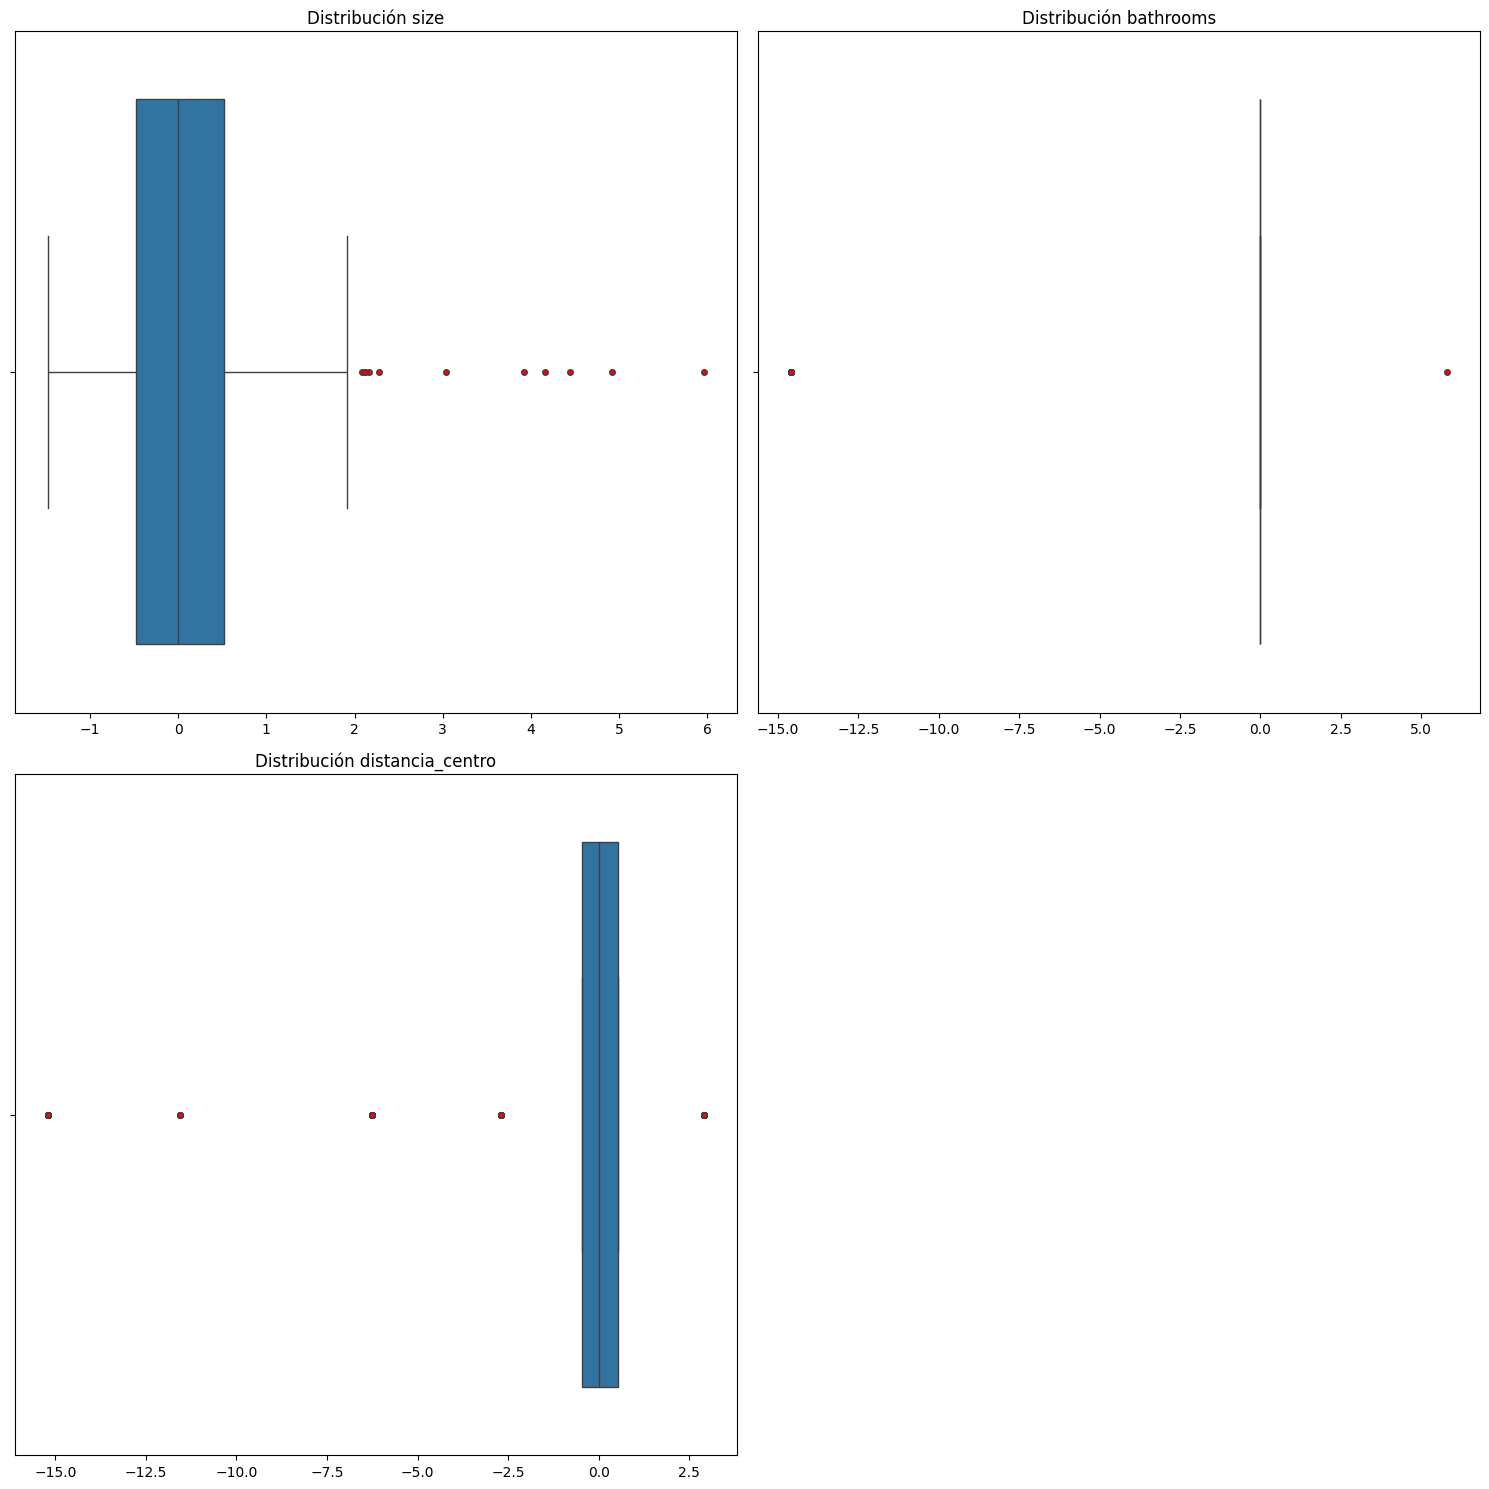

In [24]:
cols_visualizar = ["size","bathrooms","distancia_centro"]
plot_outliers_univariados(df[cols_visualizar],"b",20,(15,15))

# Veamoslo en un histplot

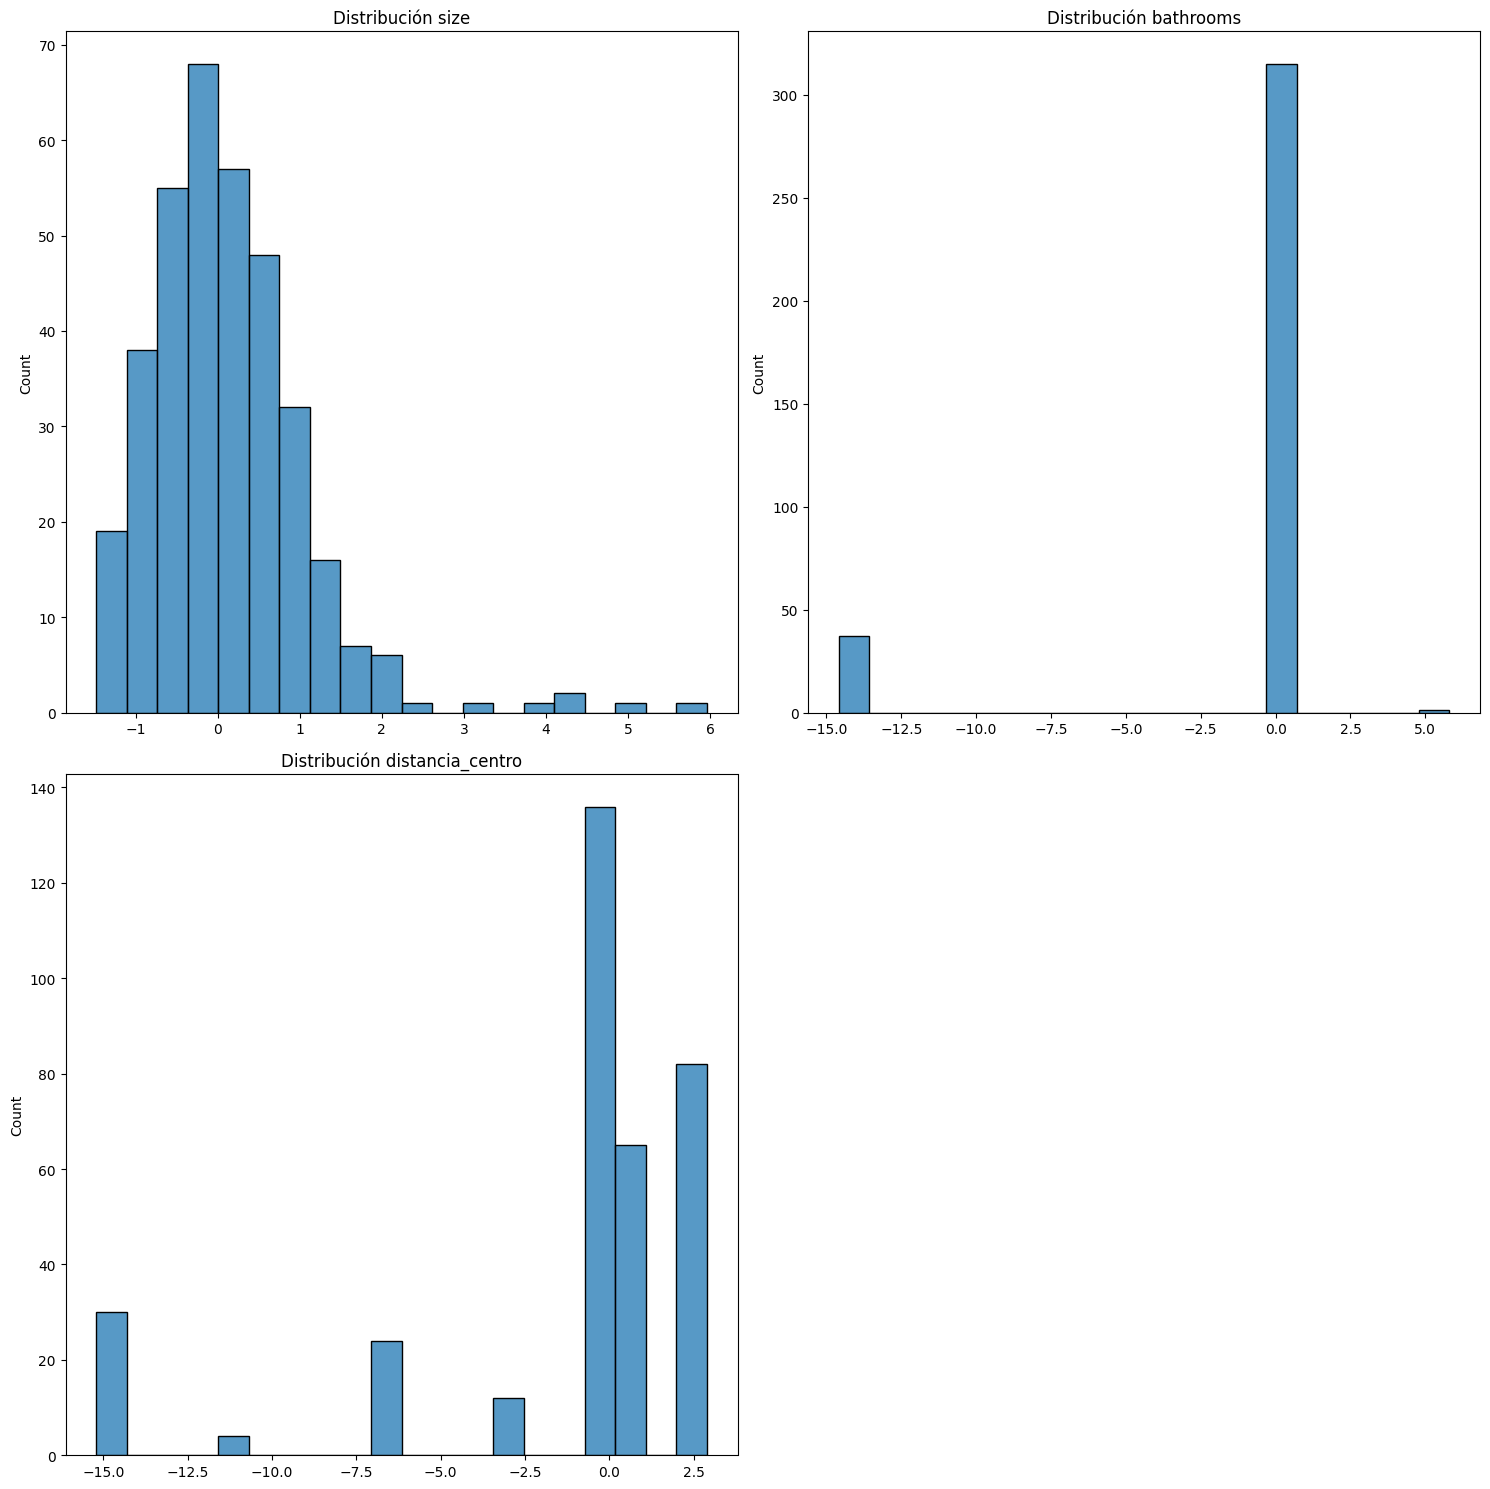

In [25]:
cols_visualizar = ["size","bathrooms","distancia_centro"]
plot_outliers_univariados(df[cols_visualizar],"h",20,(15,15))

# Identificar Outliers Multivariados

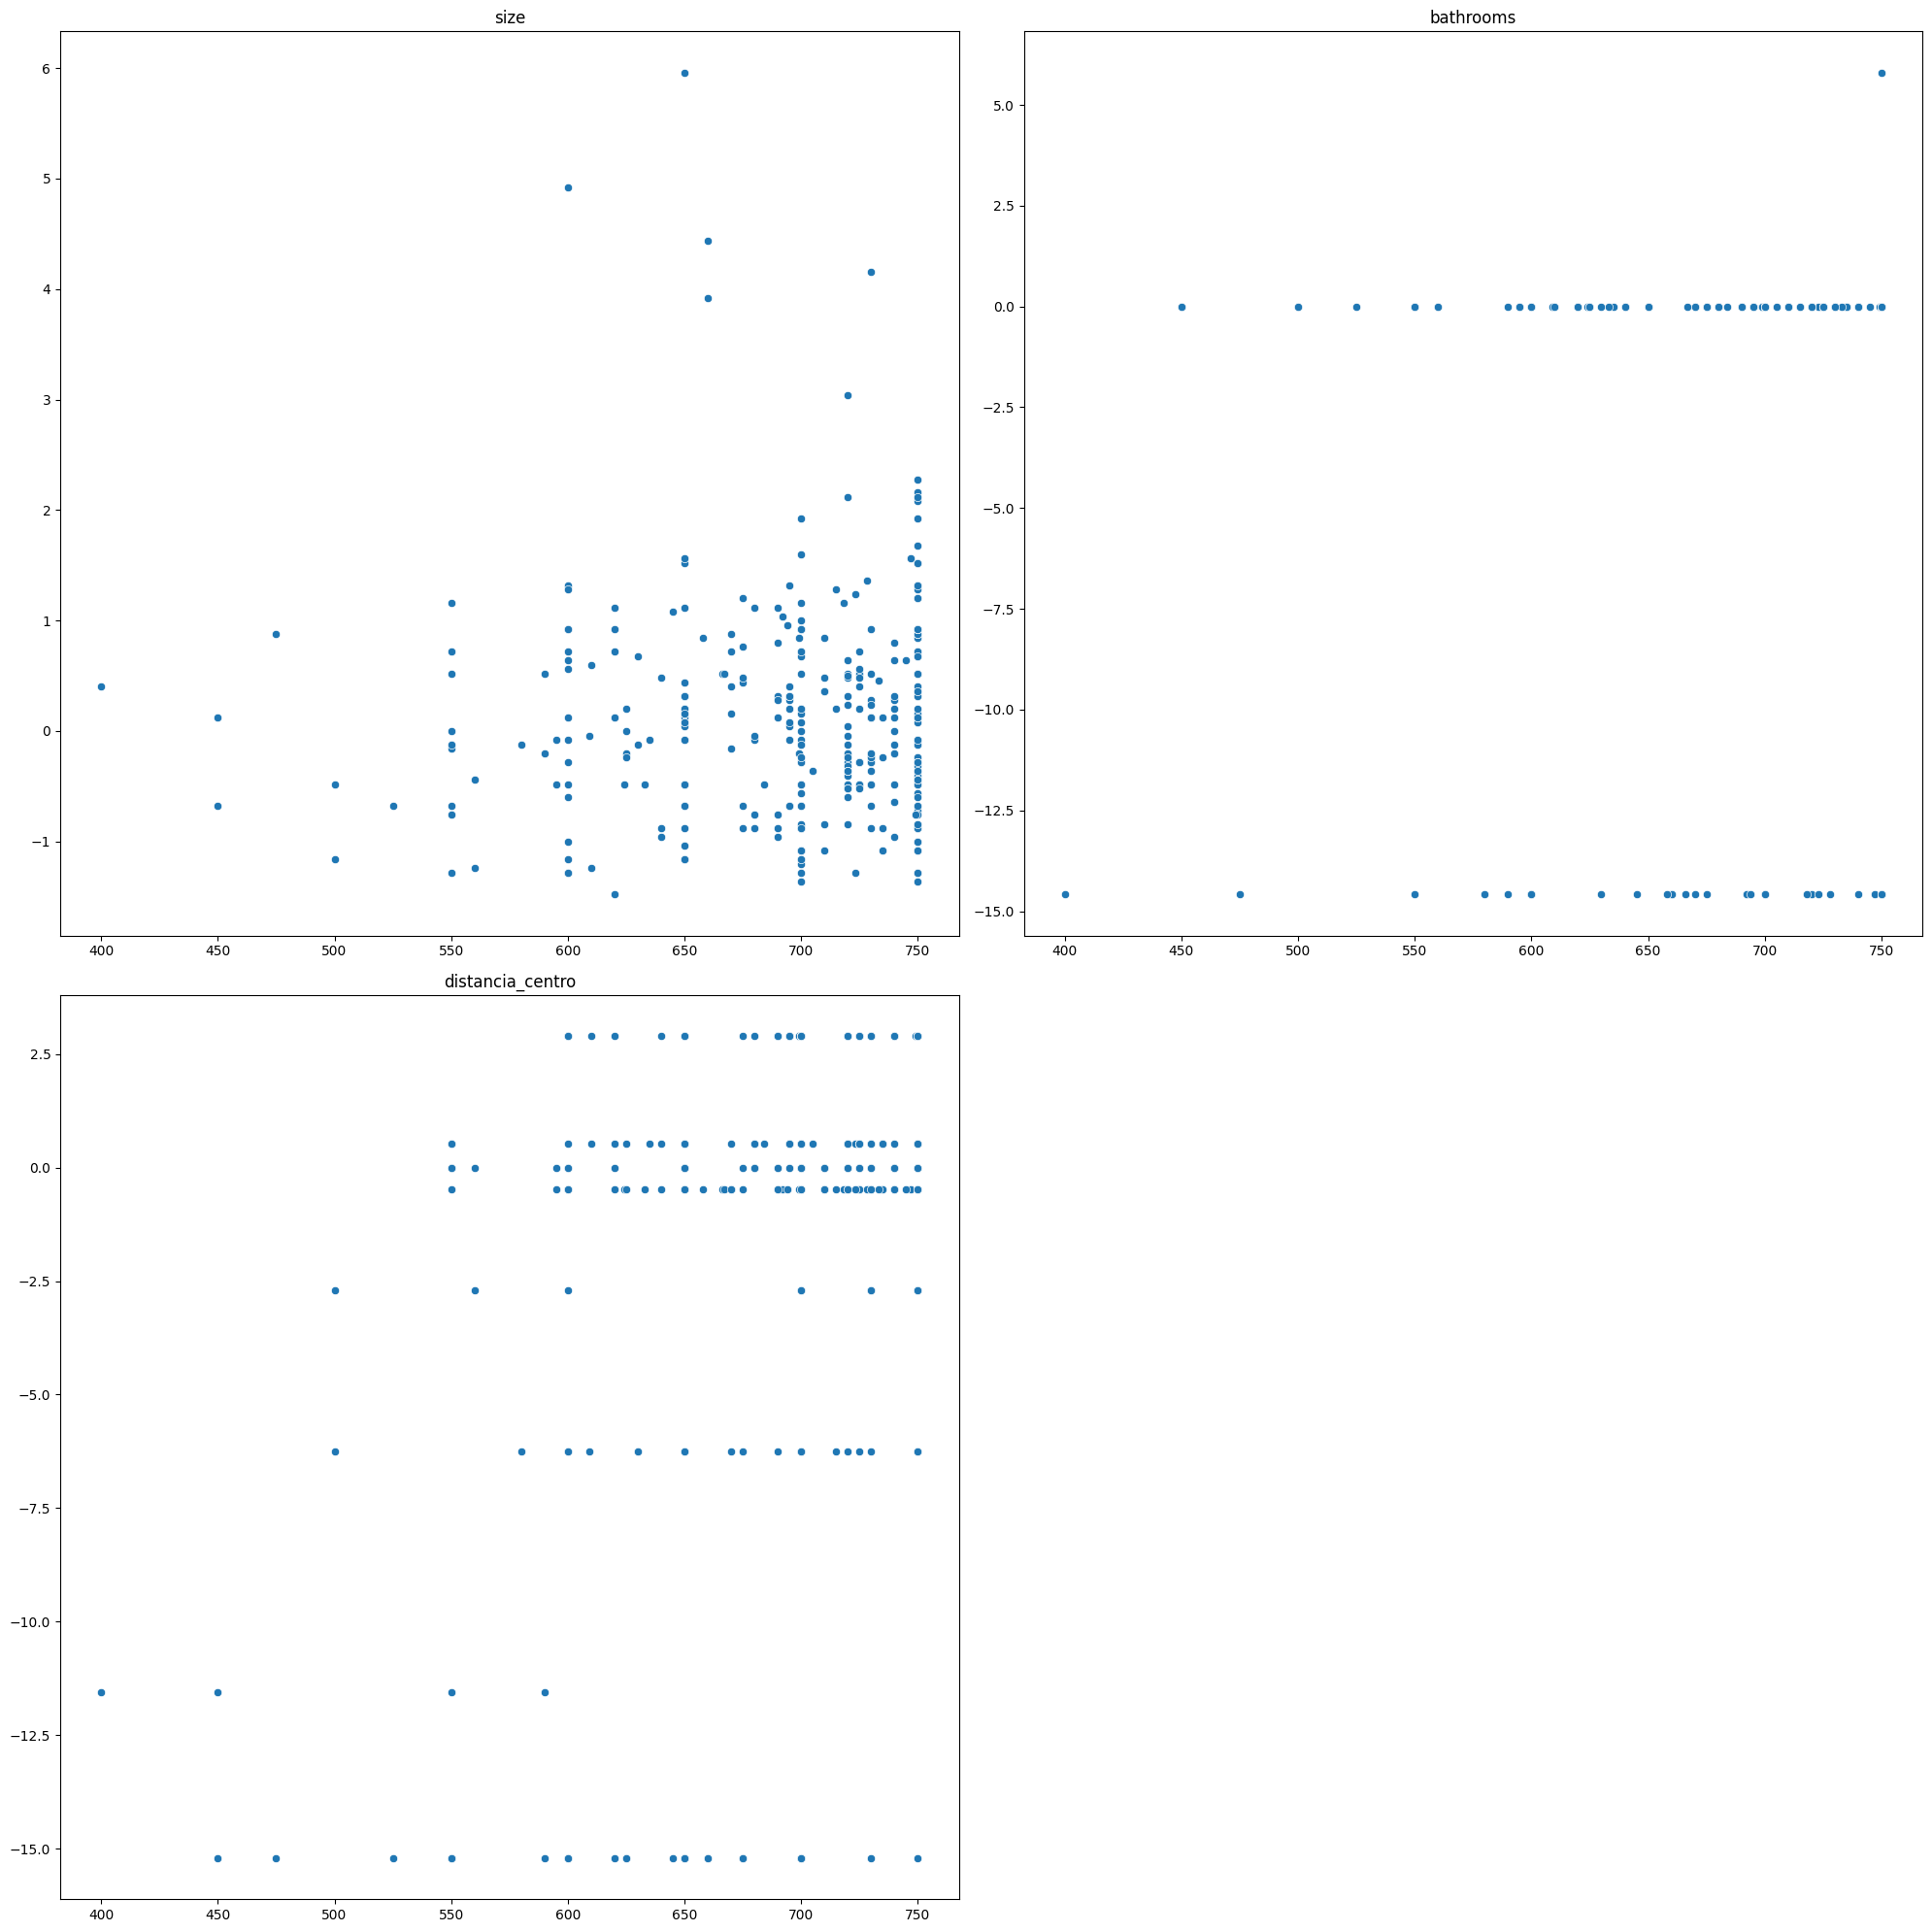

In [26]:
cols_visualizar = ["size","bathrooms","distancia_centro","price"]
visualizar_outliers_bivariados(df[cols_visualizar],"price",(20,20))

# Analicemos con IQR si hay outliers
- Solo revisamos las no binarias

In [27]:
cols_visualizar = ["size","bathrooms","distancia_centro","price"]
dictio_iqr = identificar_outliers_iqr(df[cols_visualizar])

La columna SIZE tiene 11 outliers entre el total de 353 datos, es decir un 3.1161473087818696%
La columna BATHROOMS tiene 38 outliers entre el total de 353 datos, es decir un 10.764872521246458%
La columna DISTANCIA_CENTRO tiene 152 outliers entre el total de 353 datos, es decir un 43.05949008498583%
La columna PRICE tiene 6 outliers entre el total de 353 datos, es decir un 1.69971671388102%


# Realizamos un LOF para detectar outliers

se ha hecho outlier_0.01_size_lof
se ha hecho outlier_0.01_bathrooms_lof
se ha hecho outlier_0.01_distancia_centro_lof


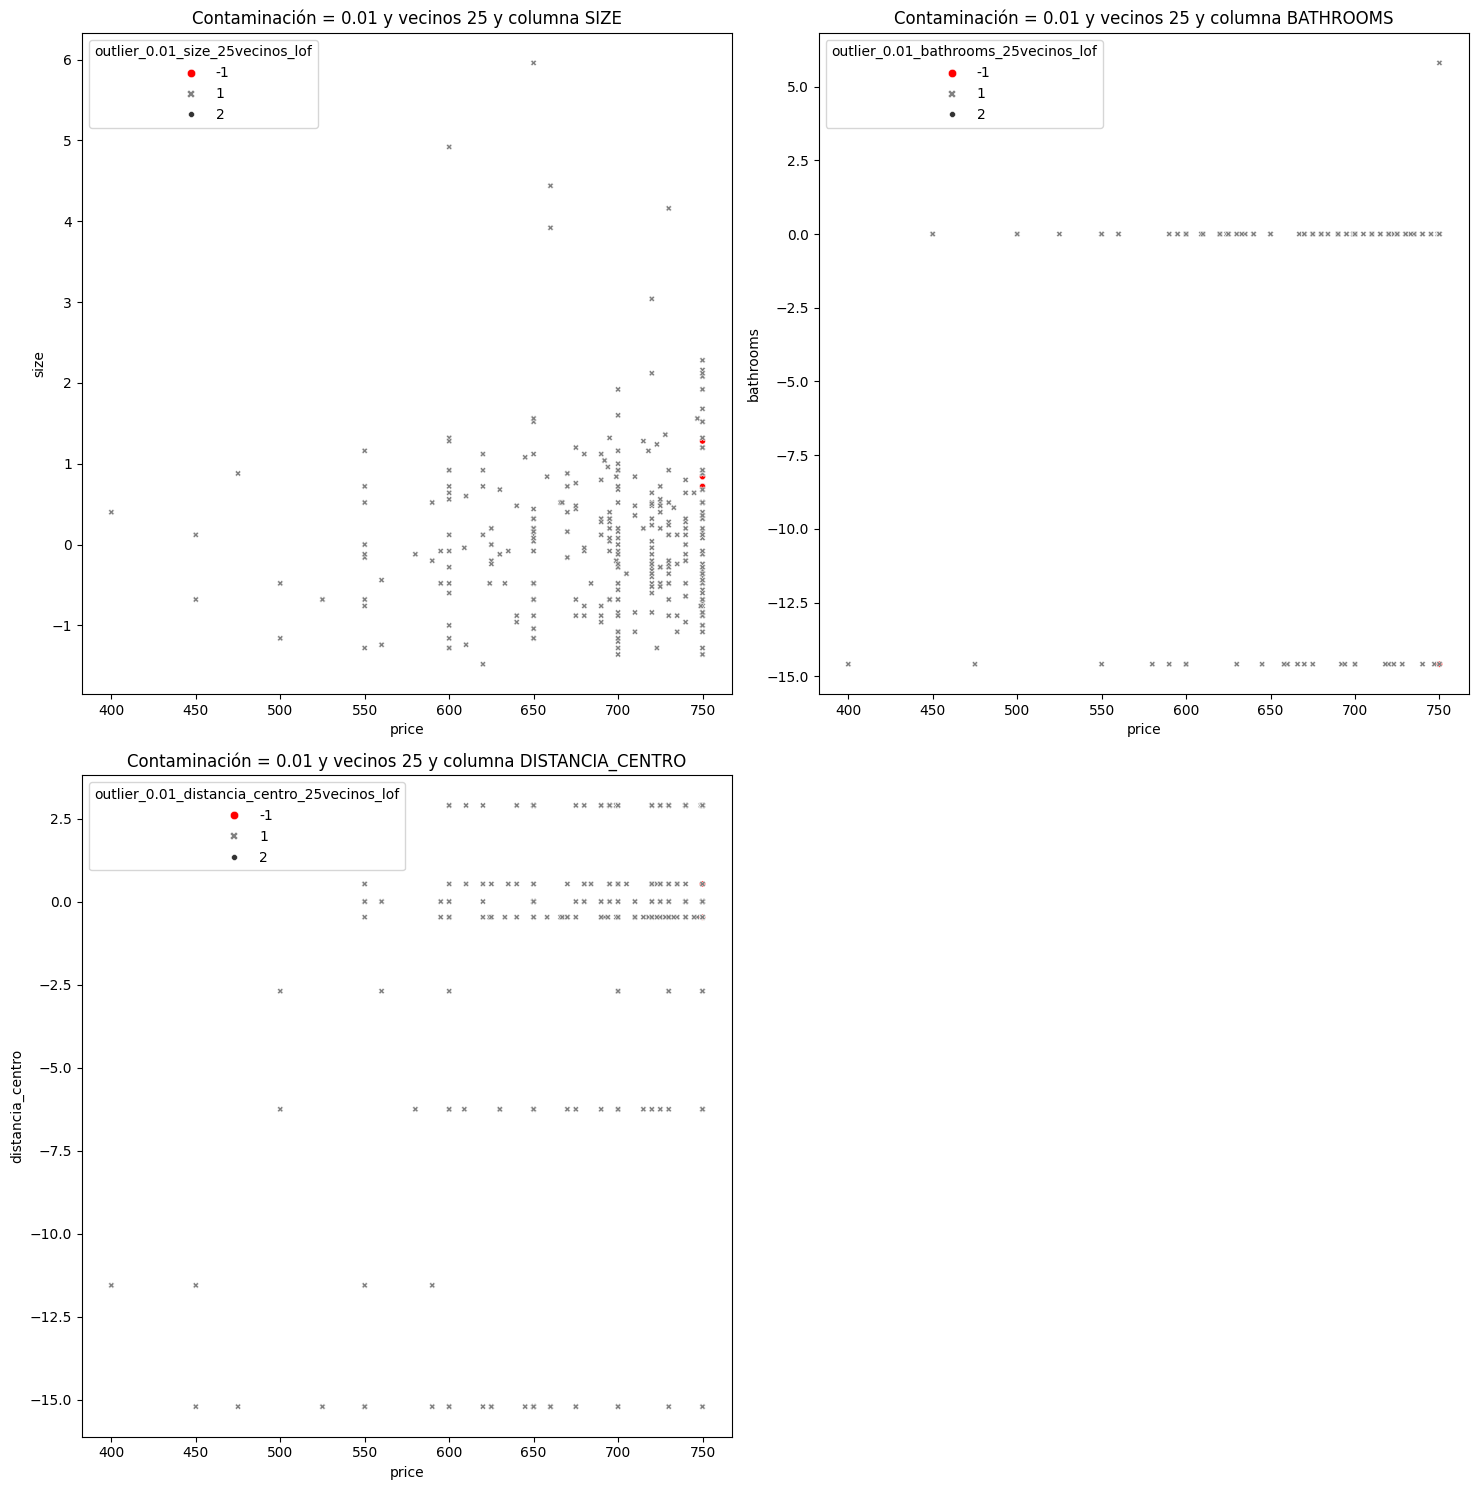

se ha hecho outlier_0.05_size_lof
se ha hecho outlier_0.05_bathrooms_lof
se ha hecho outlier_0.05_distancia_centro_lof


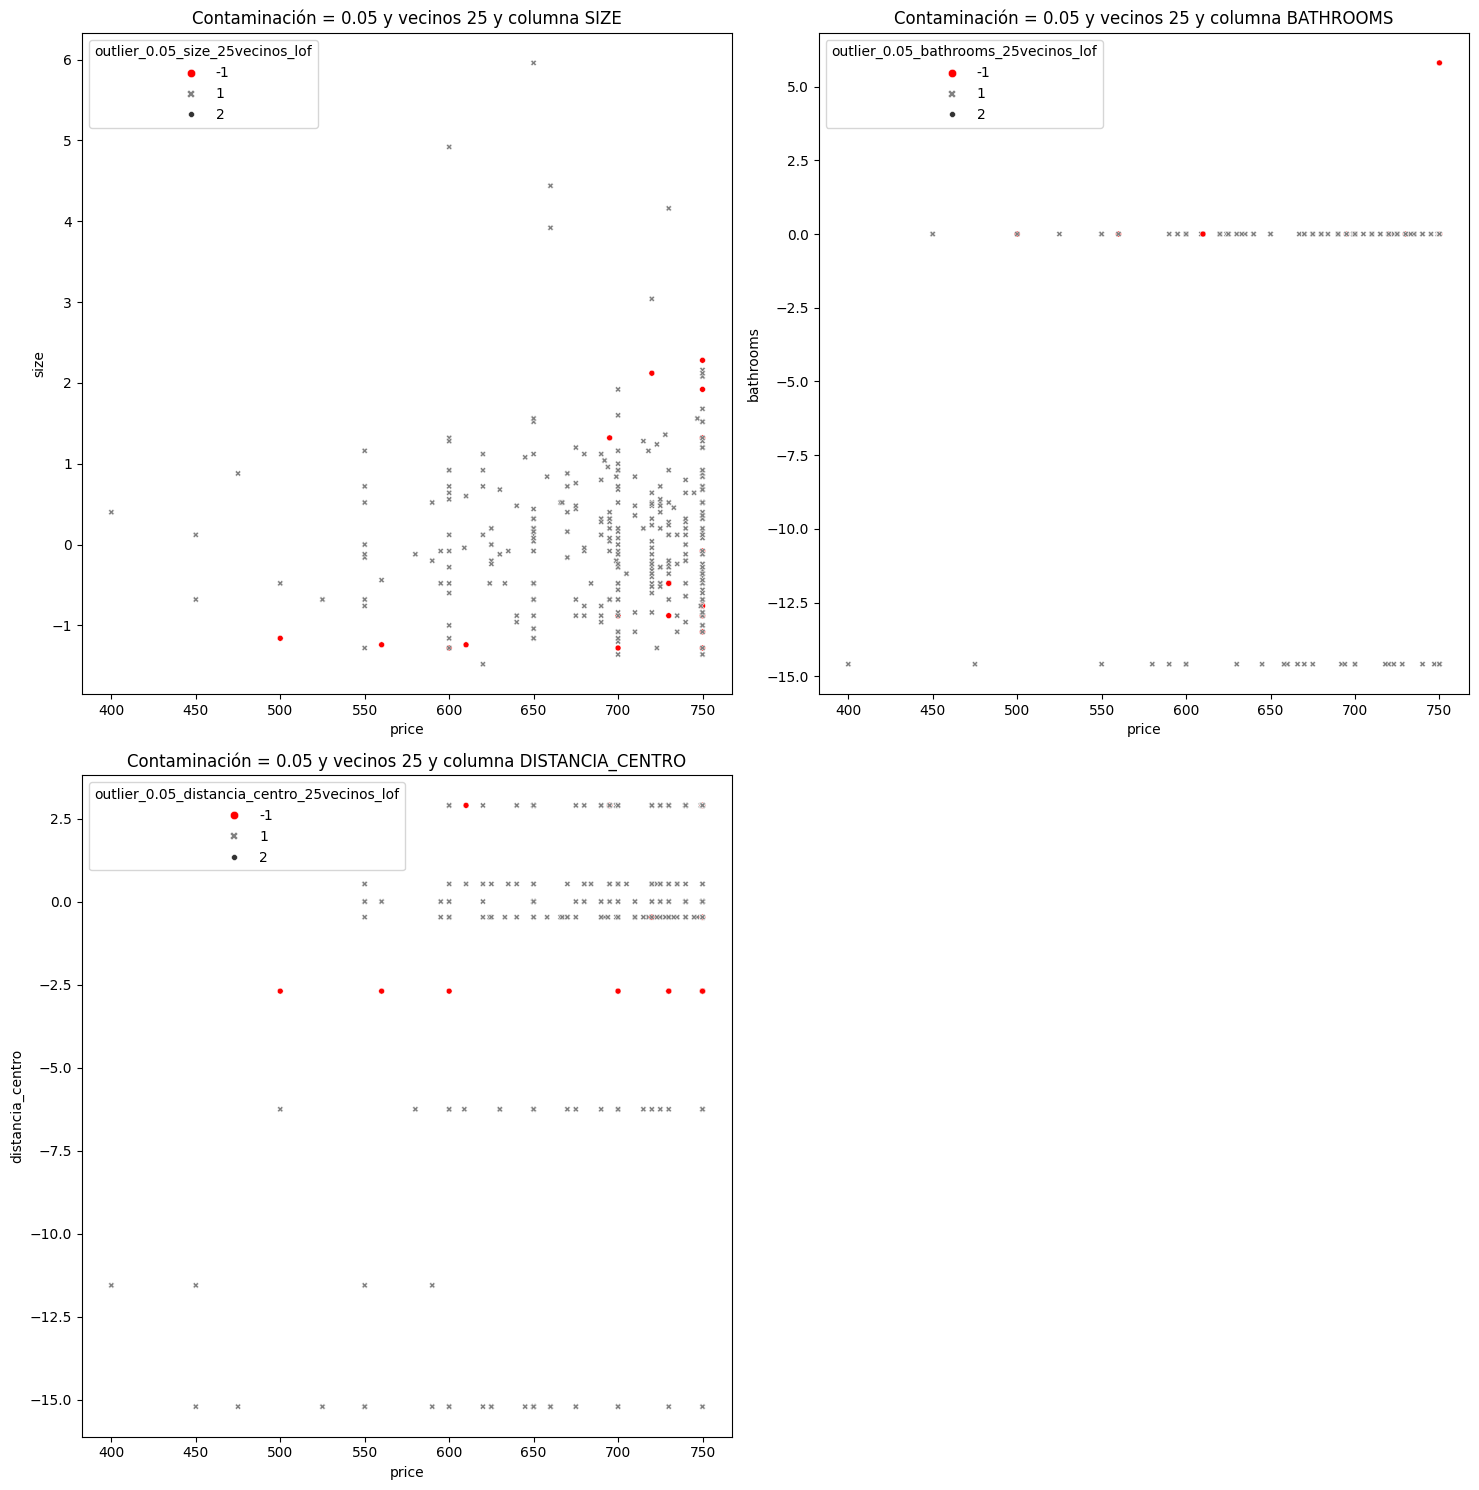

se ha hecho outlier_0.1_size_lof
se ha hecho outlier_0.1_bathrooms_lof
se ha hecho outlier_0.1_distancia_centro_lof


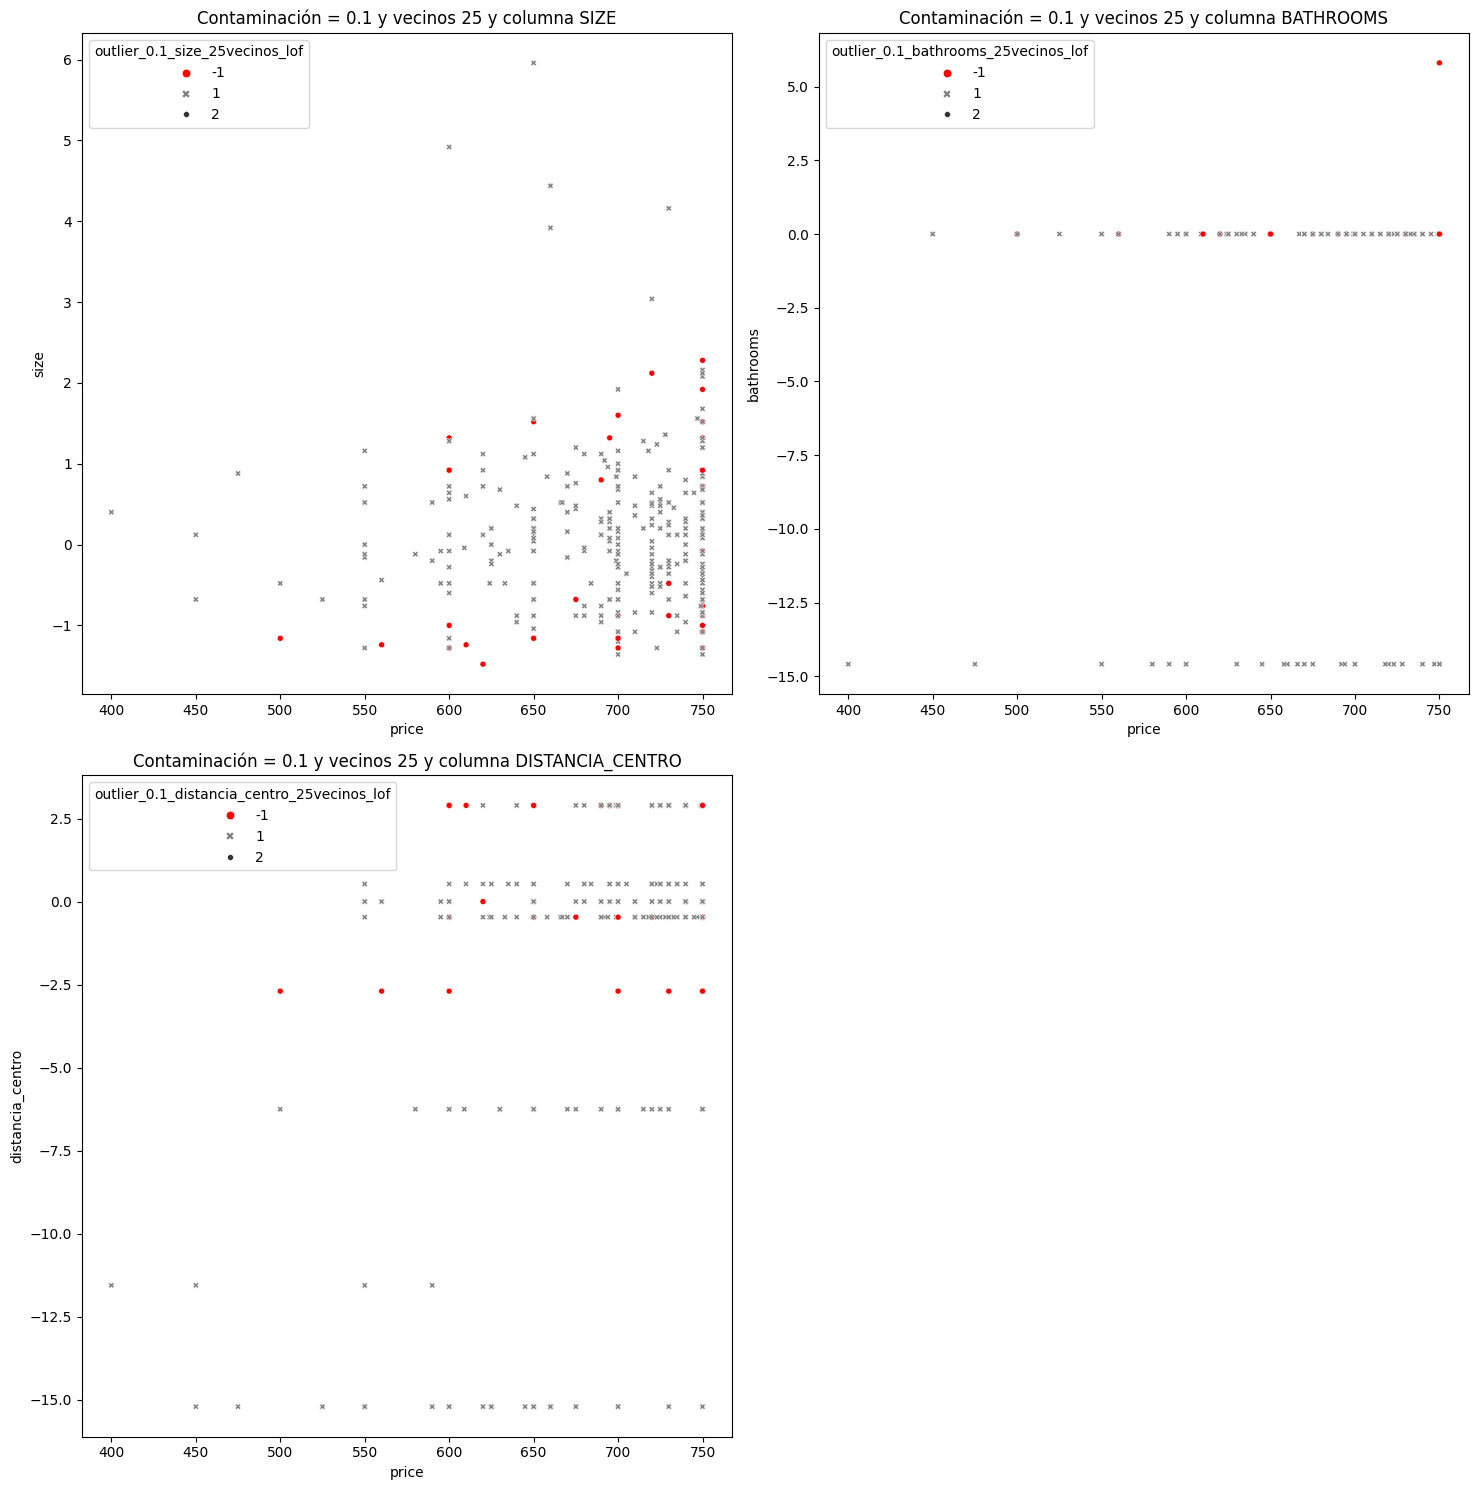

se ha hecho outlier_0.01_size_lof
se ha hecho outlier_0.01_bathrooms_lof
se ha hecho outlier_0.01_distancia_centro_lof


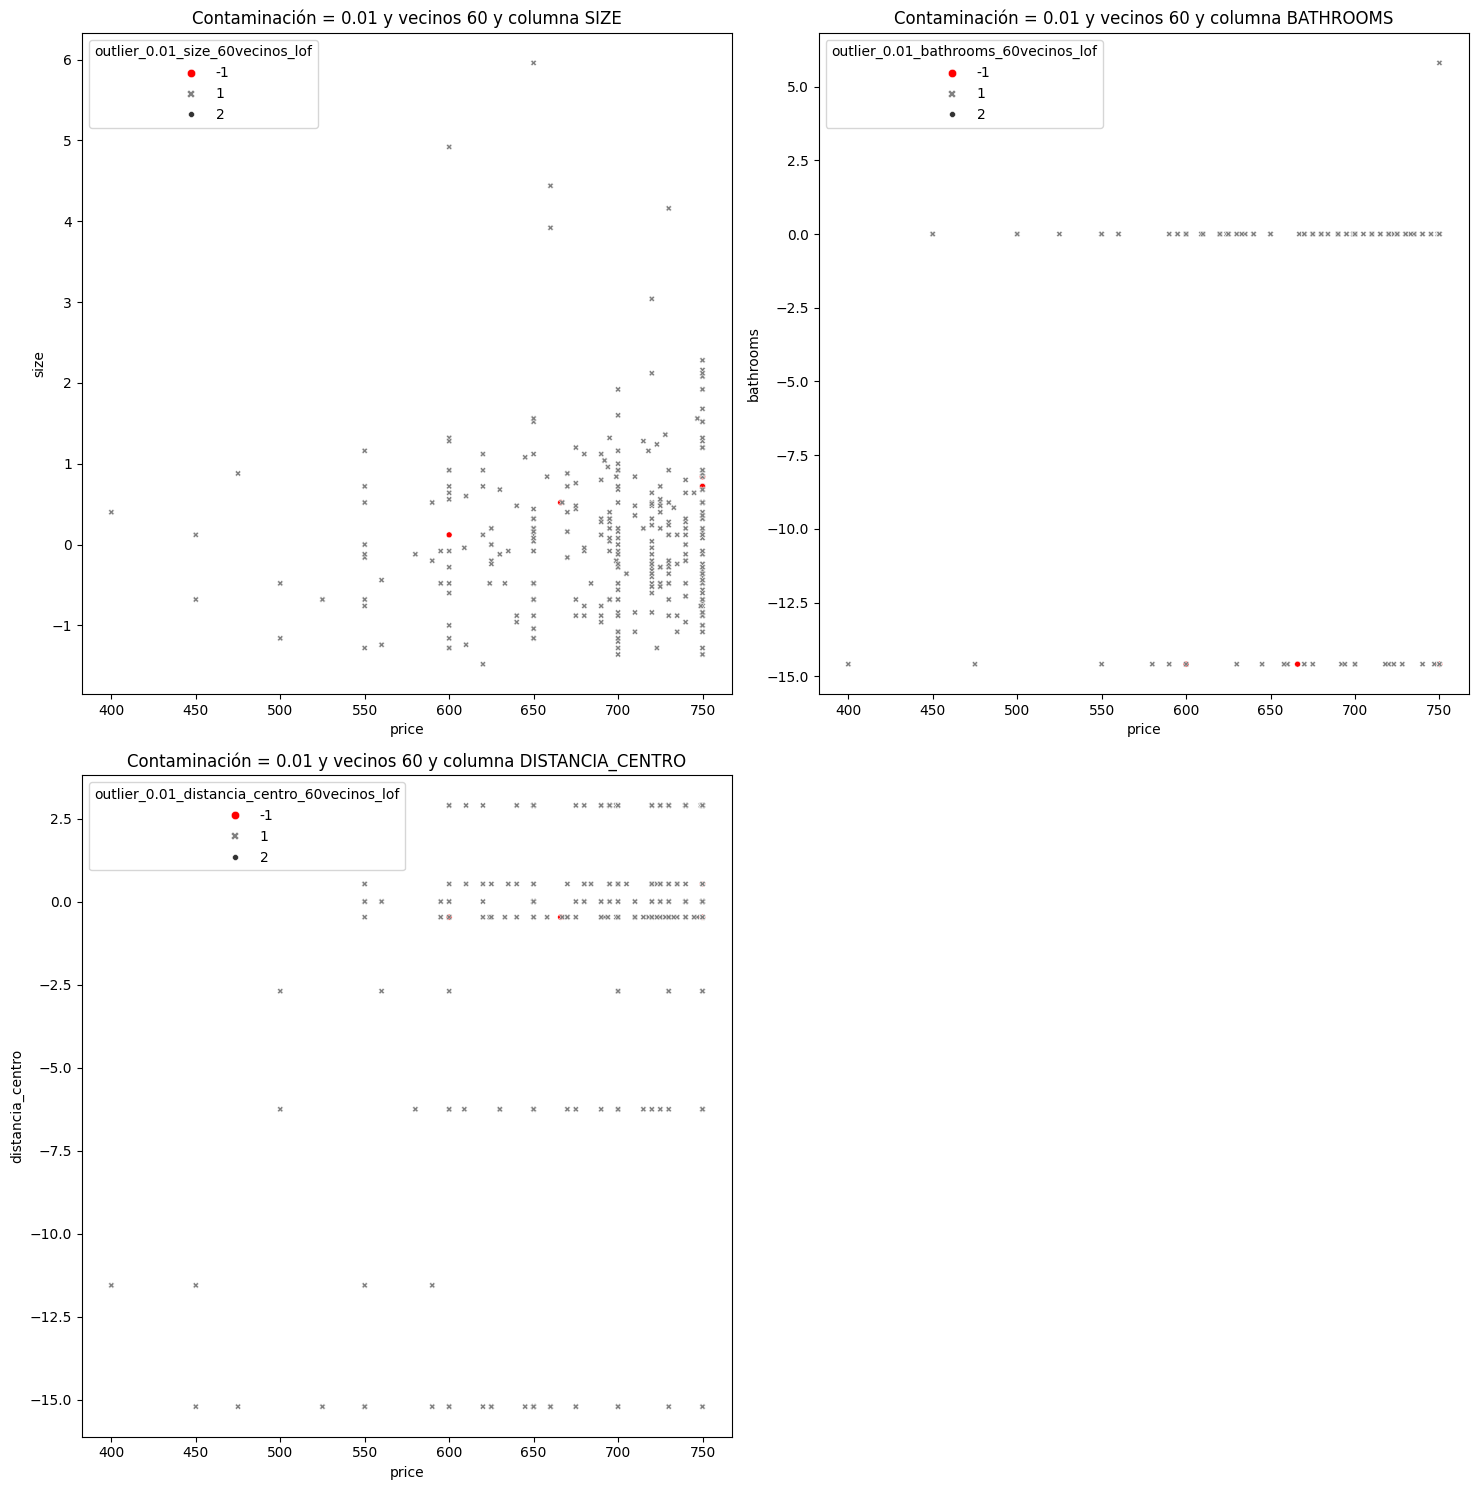

se ha hecho outlier_0.05_size_lof
se ha hecho outlier_0.05_bathrooms_lof
se ha hecho outlier_0.05_distancia_centro_lof


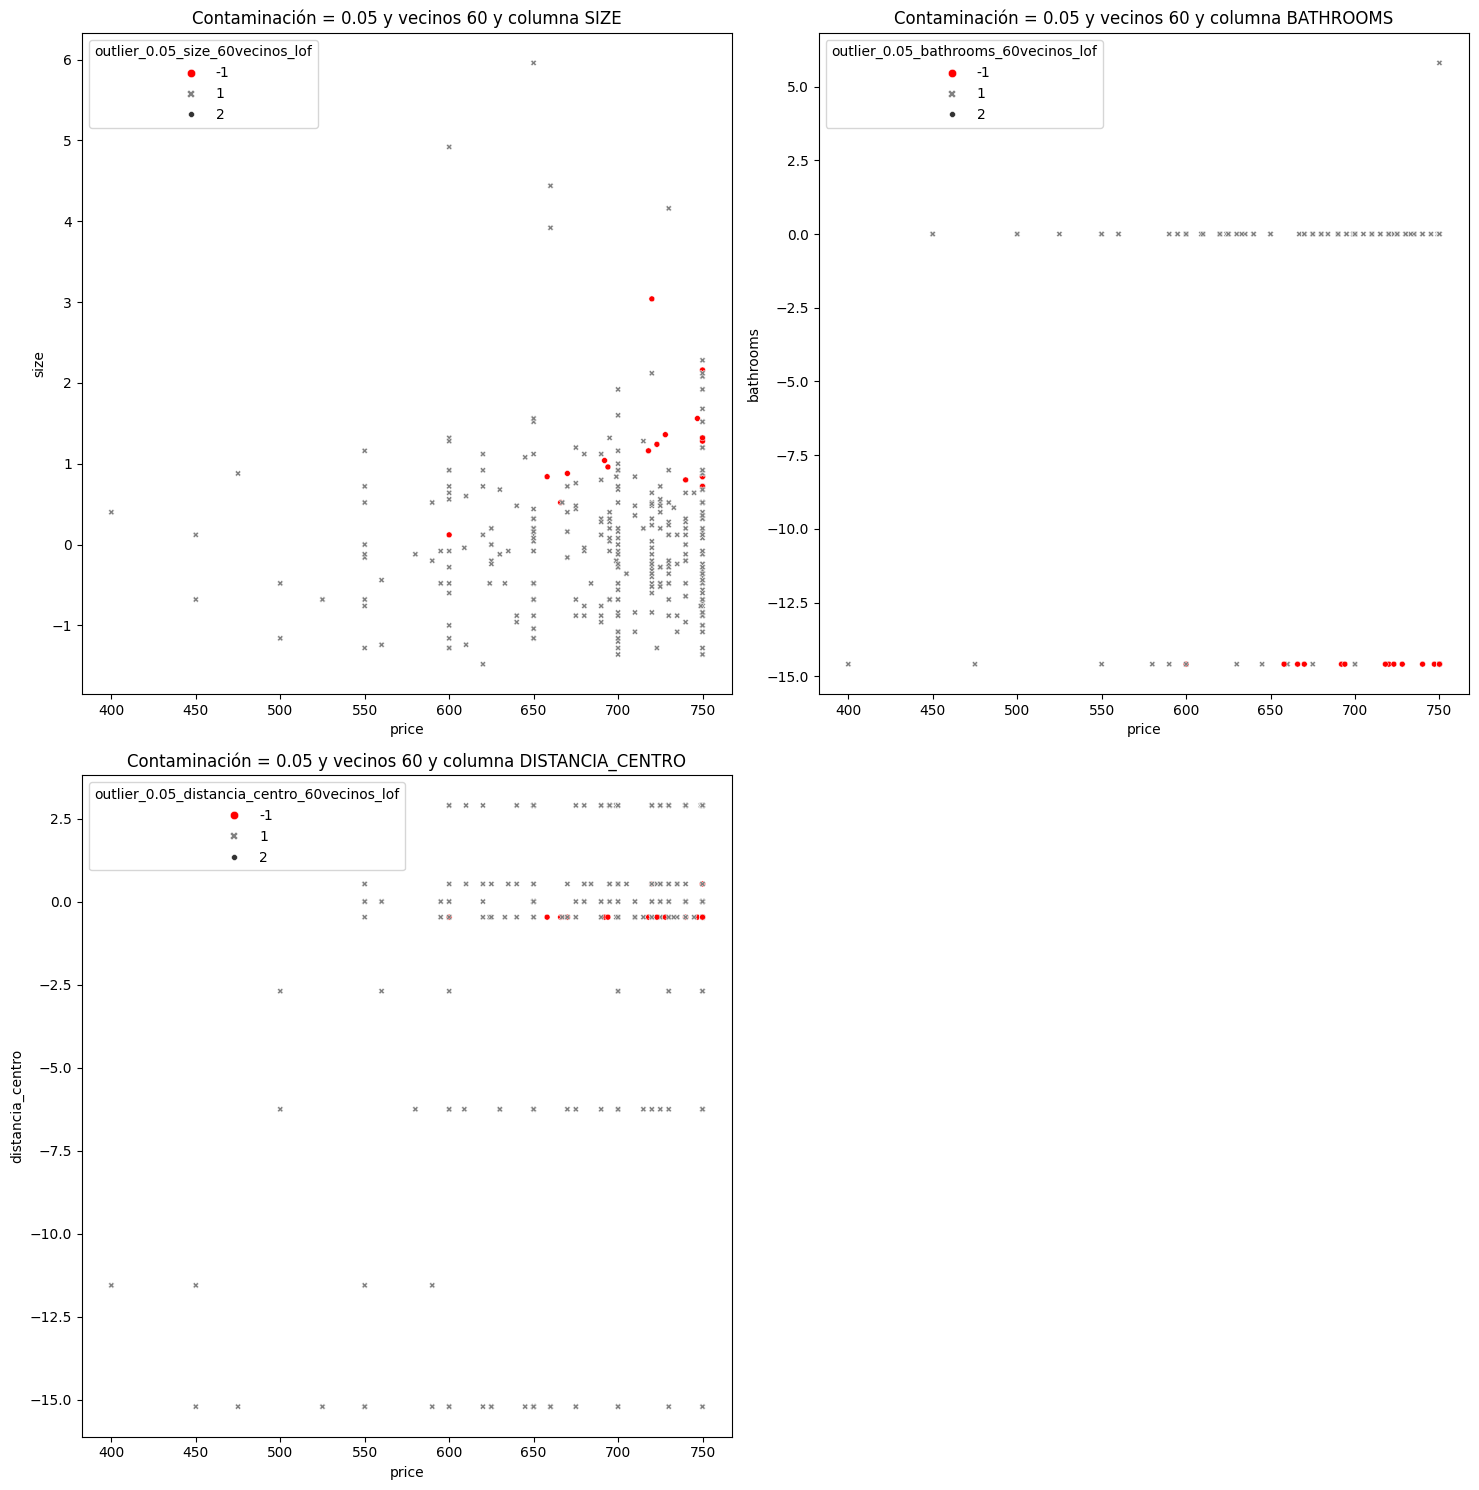

se ha hecho outlier_0.1_size_lof
se ha hecho outlier_0.1_bathrooms_lof
se ha hecho outlier_0.1_distancia_centro_lof


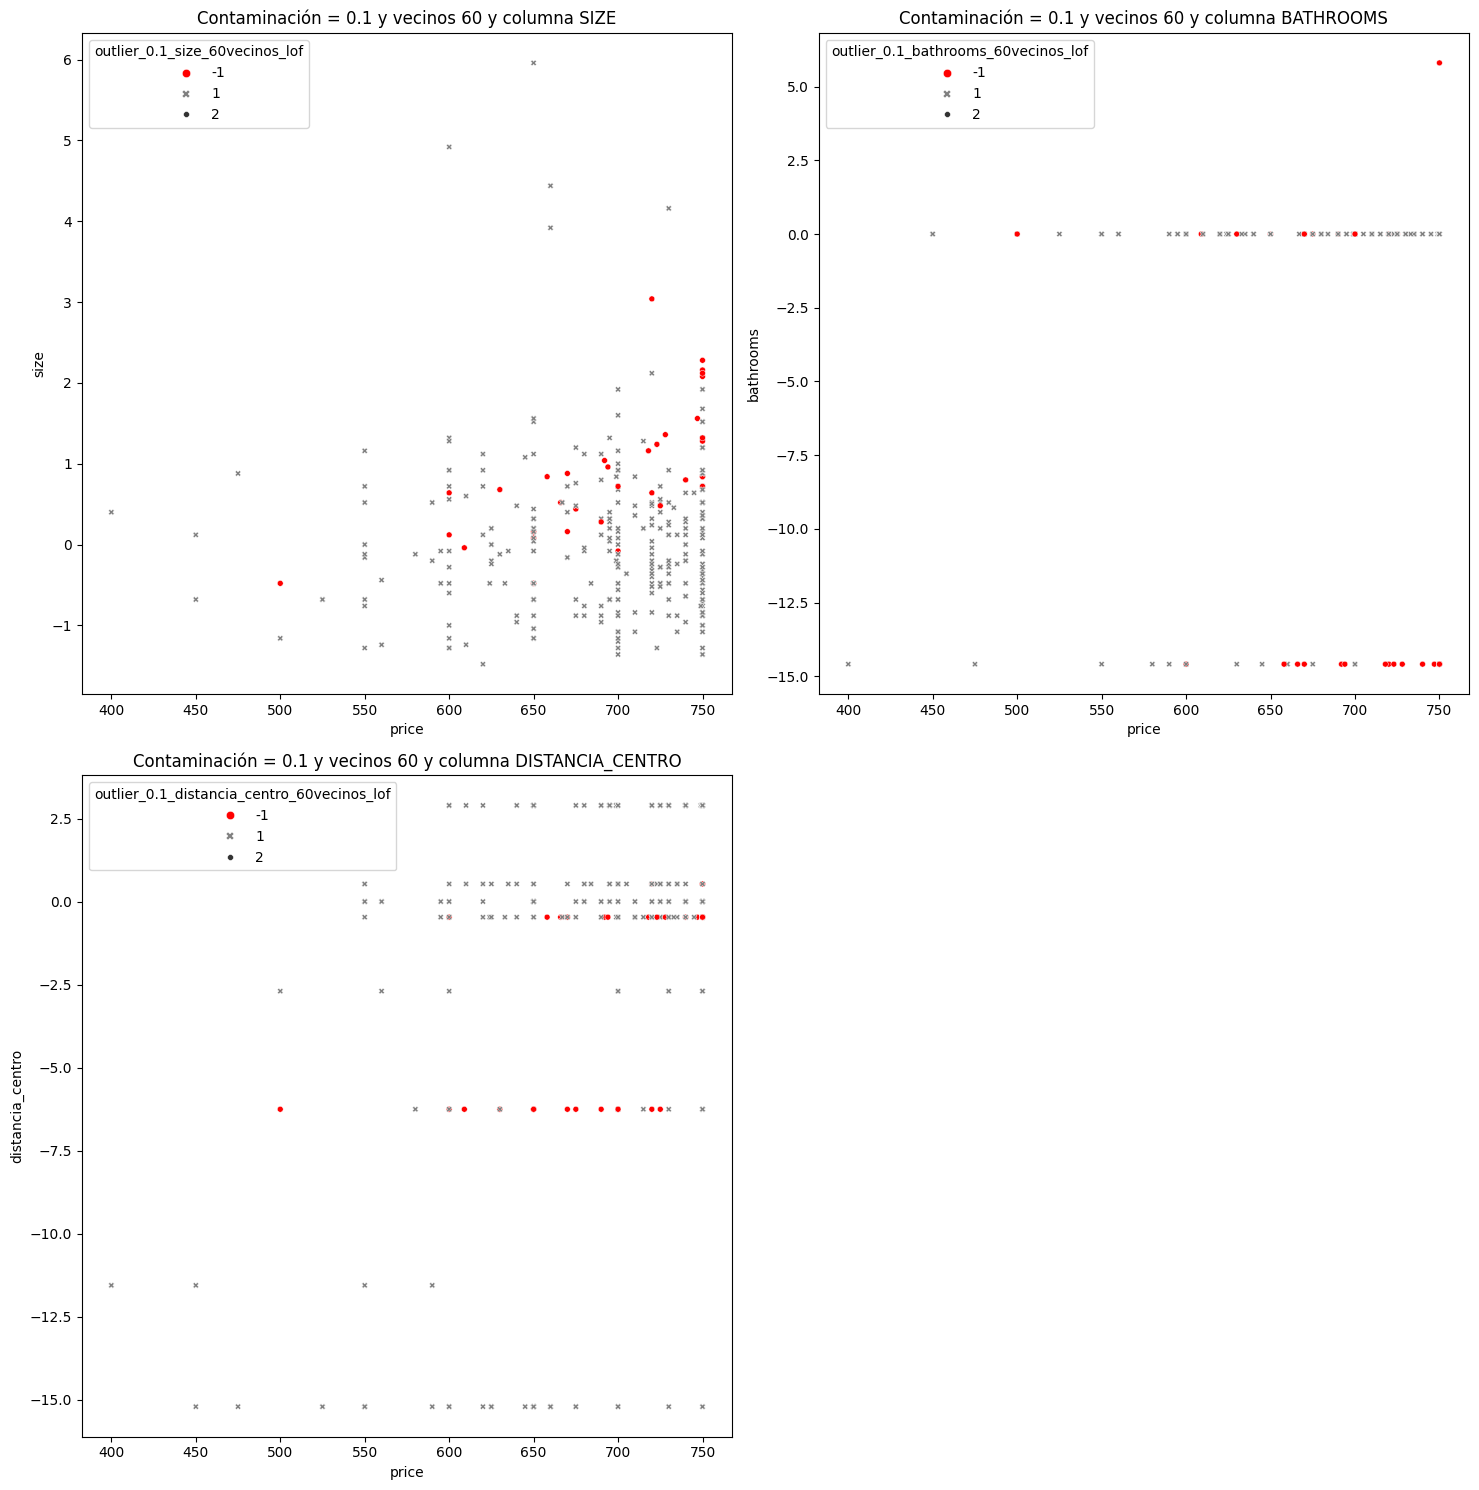

se ha hecho outlier_0.01_size_lof
se ha hecho outlier_0.01_bathrooms_lof
se ha hecho outlier_0.01_distancia_centro_lof


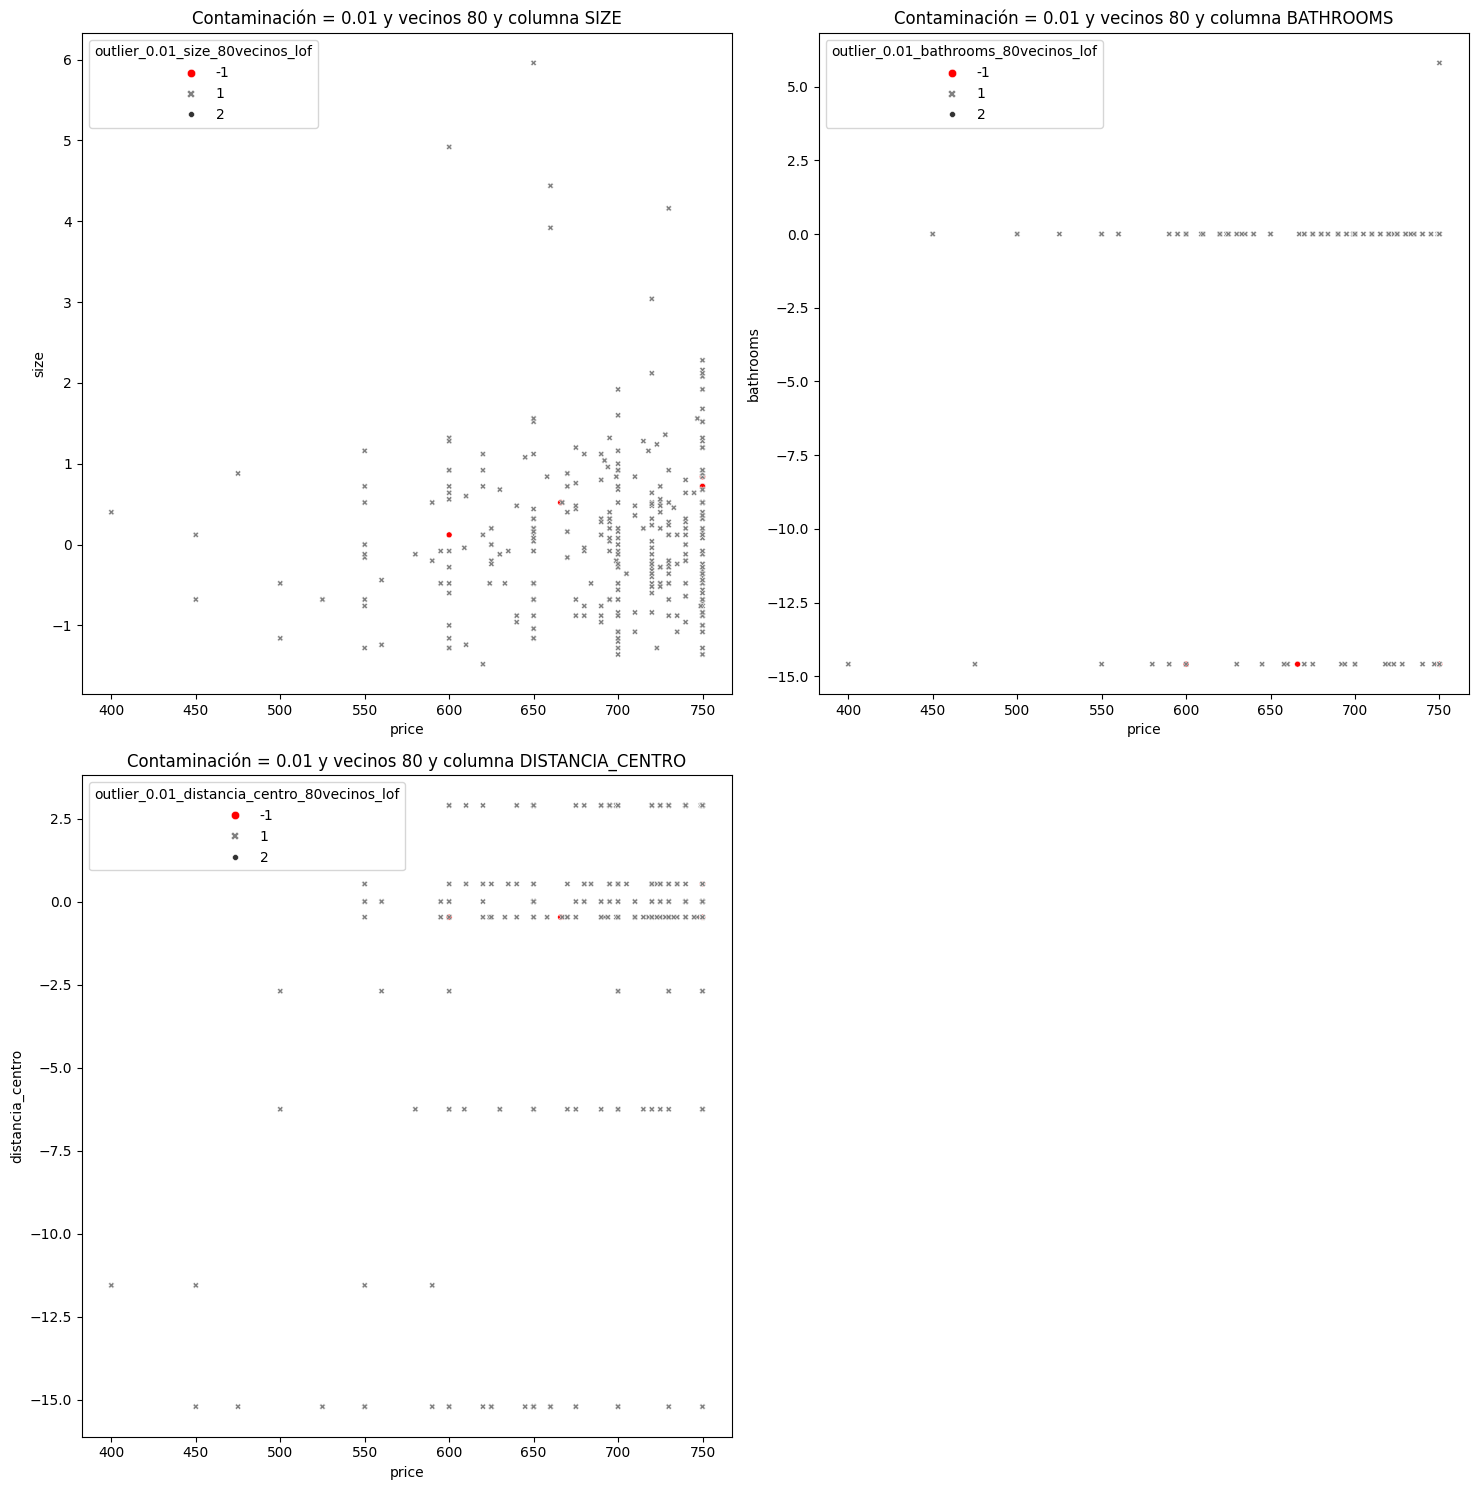

se ha hecho outlier_0.05_size_lof
se ha hecho outlier_0.05_bathrooms_lof
se ha hecho outlier_0.05_distancia_centro_lof


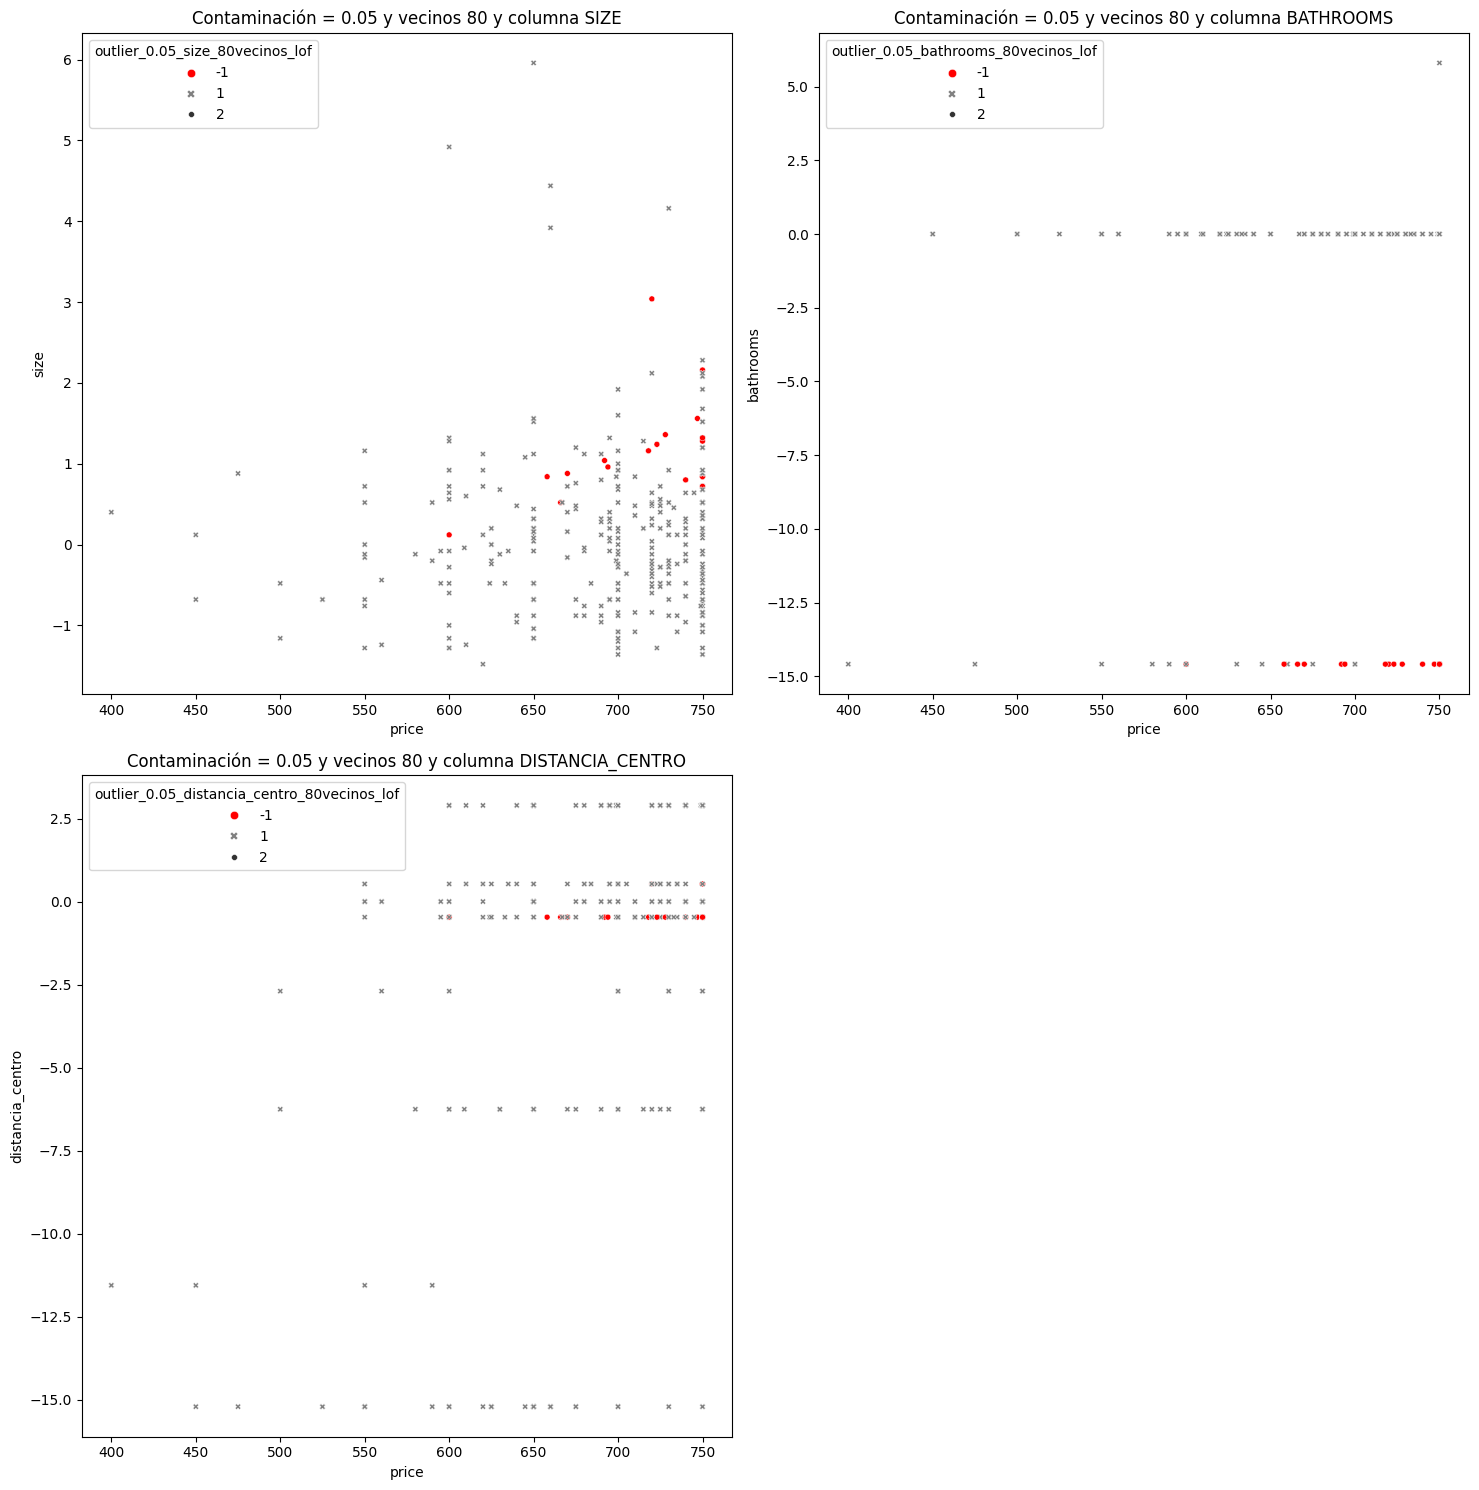

se ha hecho outlier_0.1_size_lof
se ha hecho outlier_0.1_bathrooms_lof
se ha hecho outlier_0.1_distancia_centro_lof


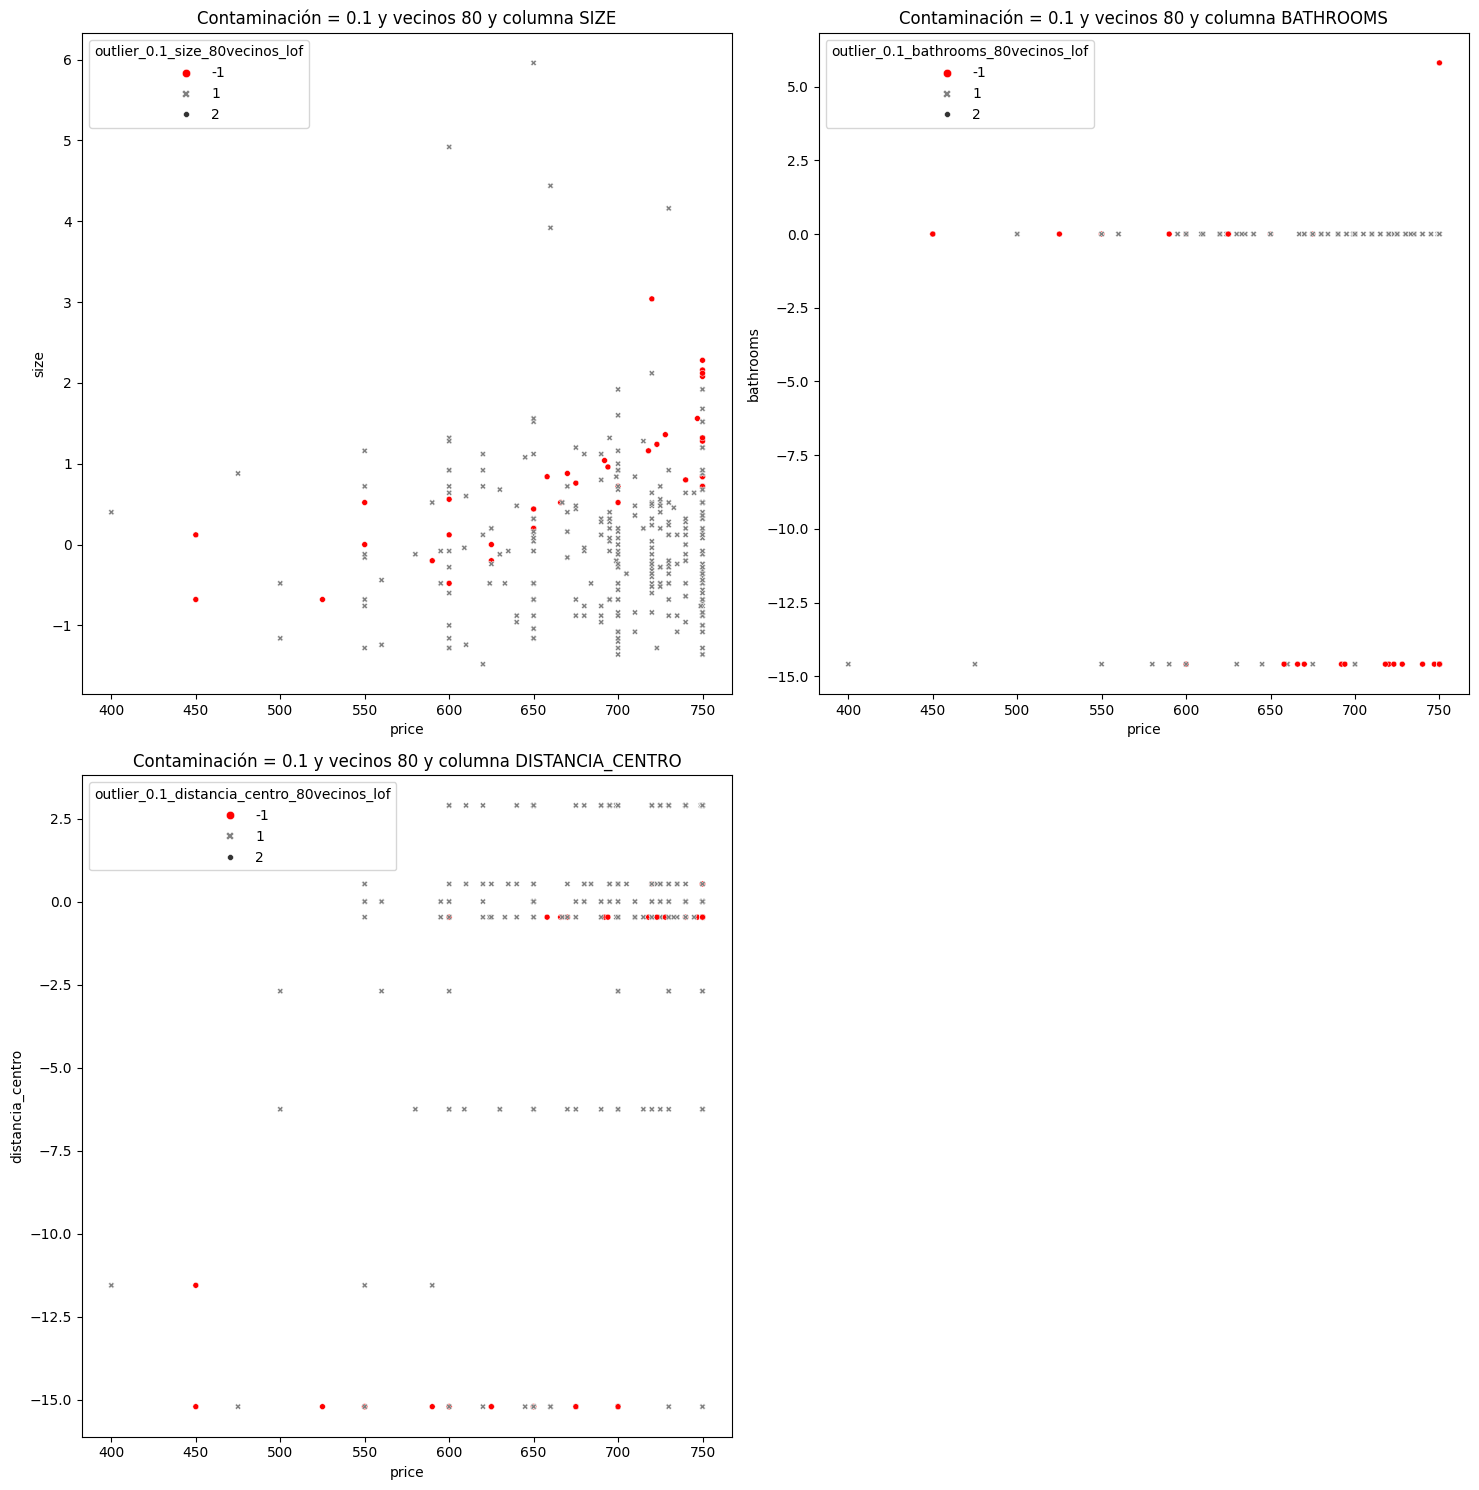

Se devuelve df Modificado


In [28]:
cols_analizar = ["size","bathrooms","district","distancia_centro","price"]
df_lof = explorar_outliers_lof(df[cols_visualizar],df,"price",vecinos=[25,60,80],grafica_size=(15,15))

In [29]:
df_lof.sample()

,size,bathrooms,distancia_centro,price,propertyType_chalet,propertyType_countryHouse,propertyType_duplex,propertyType_flat,propertyType_penthouse,propertyType_studio,...,outlier_0.1_distancia_centro_60vecinos_lof,outlier_0.01_size_80vecinos_lof,outlier_0.01_bathrooms_80vecinos_lof,outlier_0.01_distancia_centro_80vecinos_lof,outlier_0.05_size_80vecinos_lof,outlier_0.05_bathrooms_80vecinos_lof,outlier_0.05_distancia_centro_80vecinos_lof,outlier_0.1_size_80vecinos_lof,outlier_0.1_bathrooms_80vecinos_lof,outlier_0.1_distancia_centro_80vecinos_lof
34,-0.88,0.0,2.895607,640.0,0.0,0.0,0.0,0.0,0.0,1.0,...,1,1,1,1,1,1,1,1,1,1


# Veamos con Isolation Forest

se ha hecho outlier_0.01_price_isoforest
se ha hecho outlier_0.05_price_isoforest
se ha hecho outlier_0.1_price_isoforest
Se devuelve df Modificado


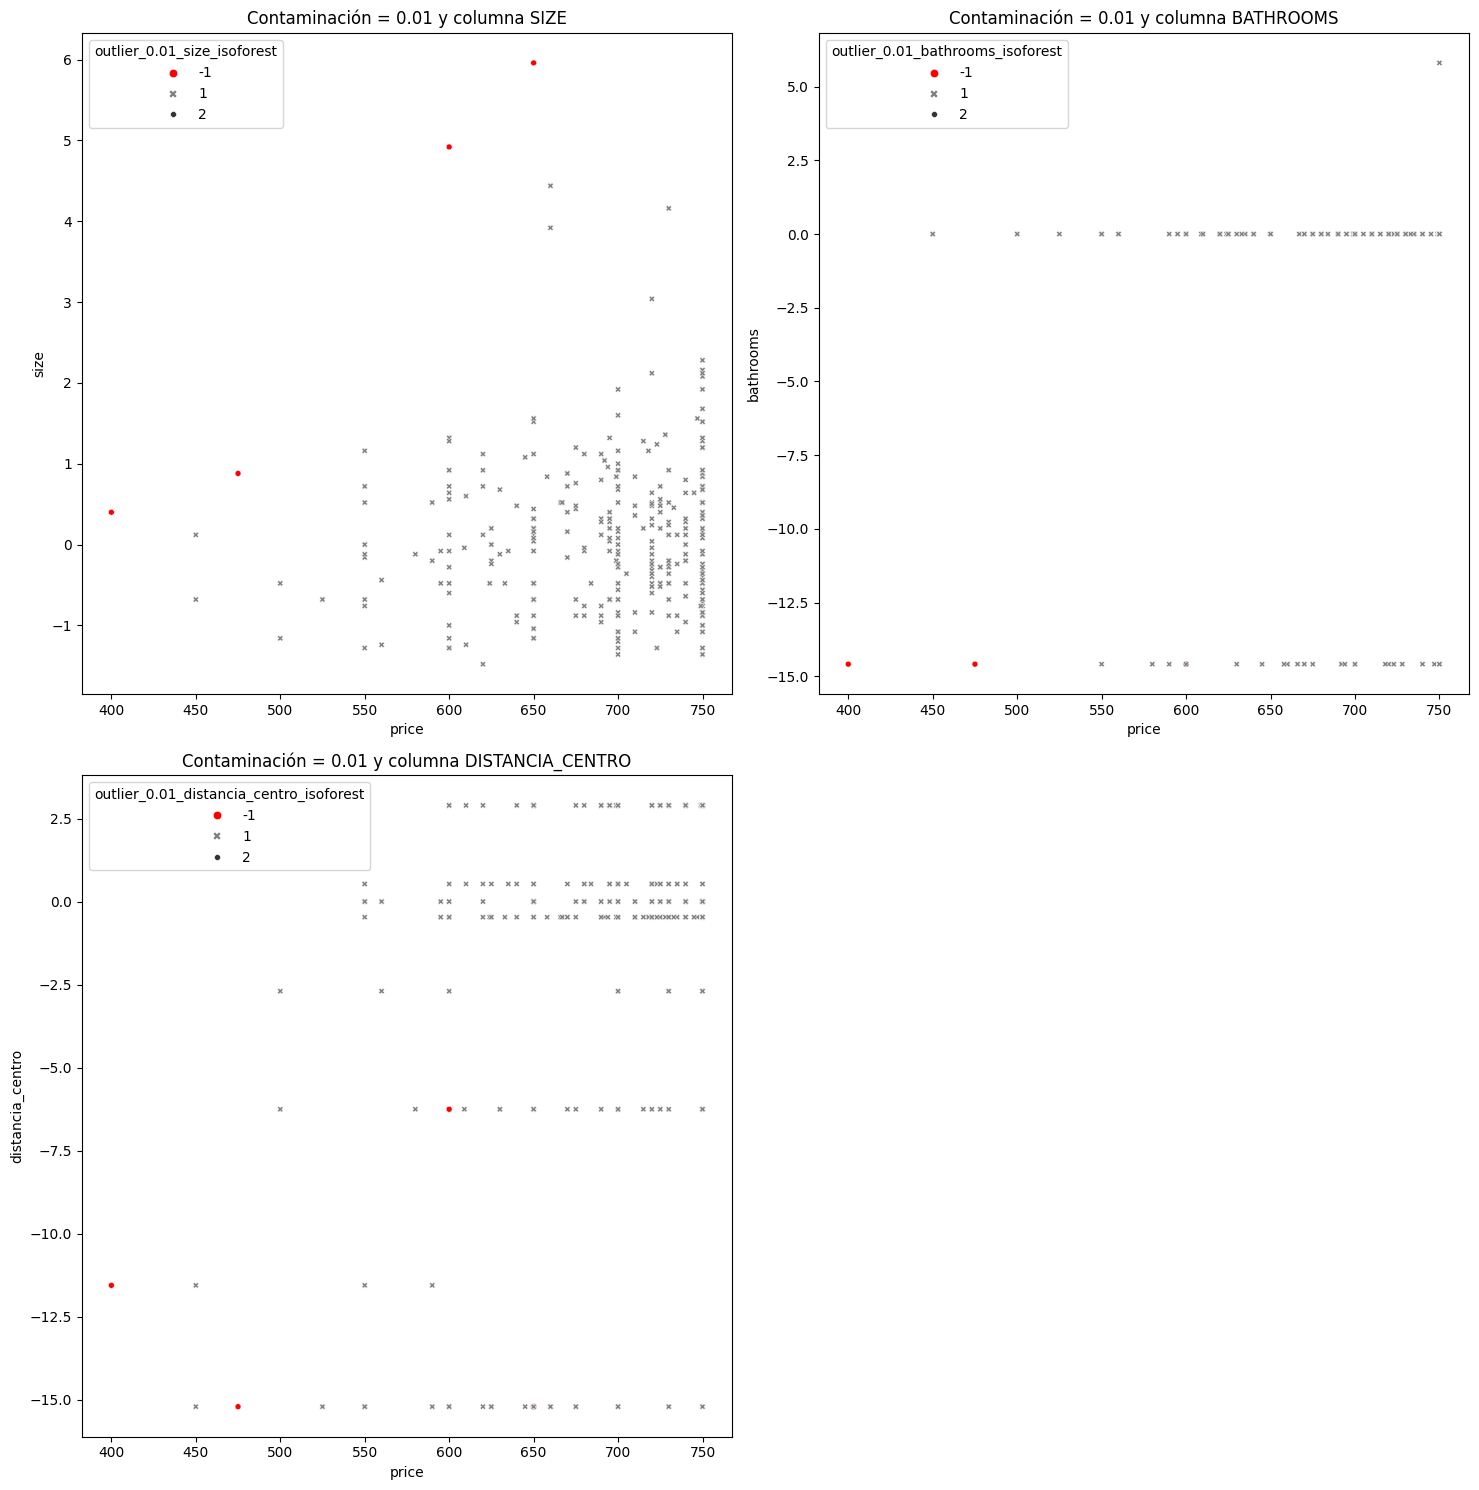

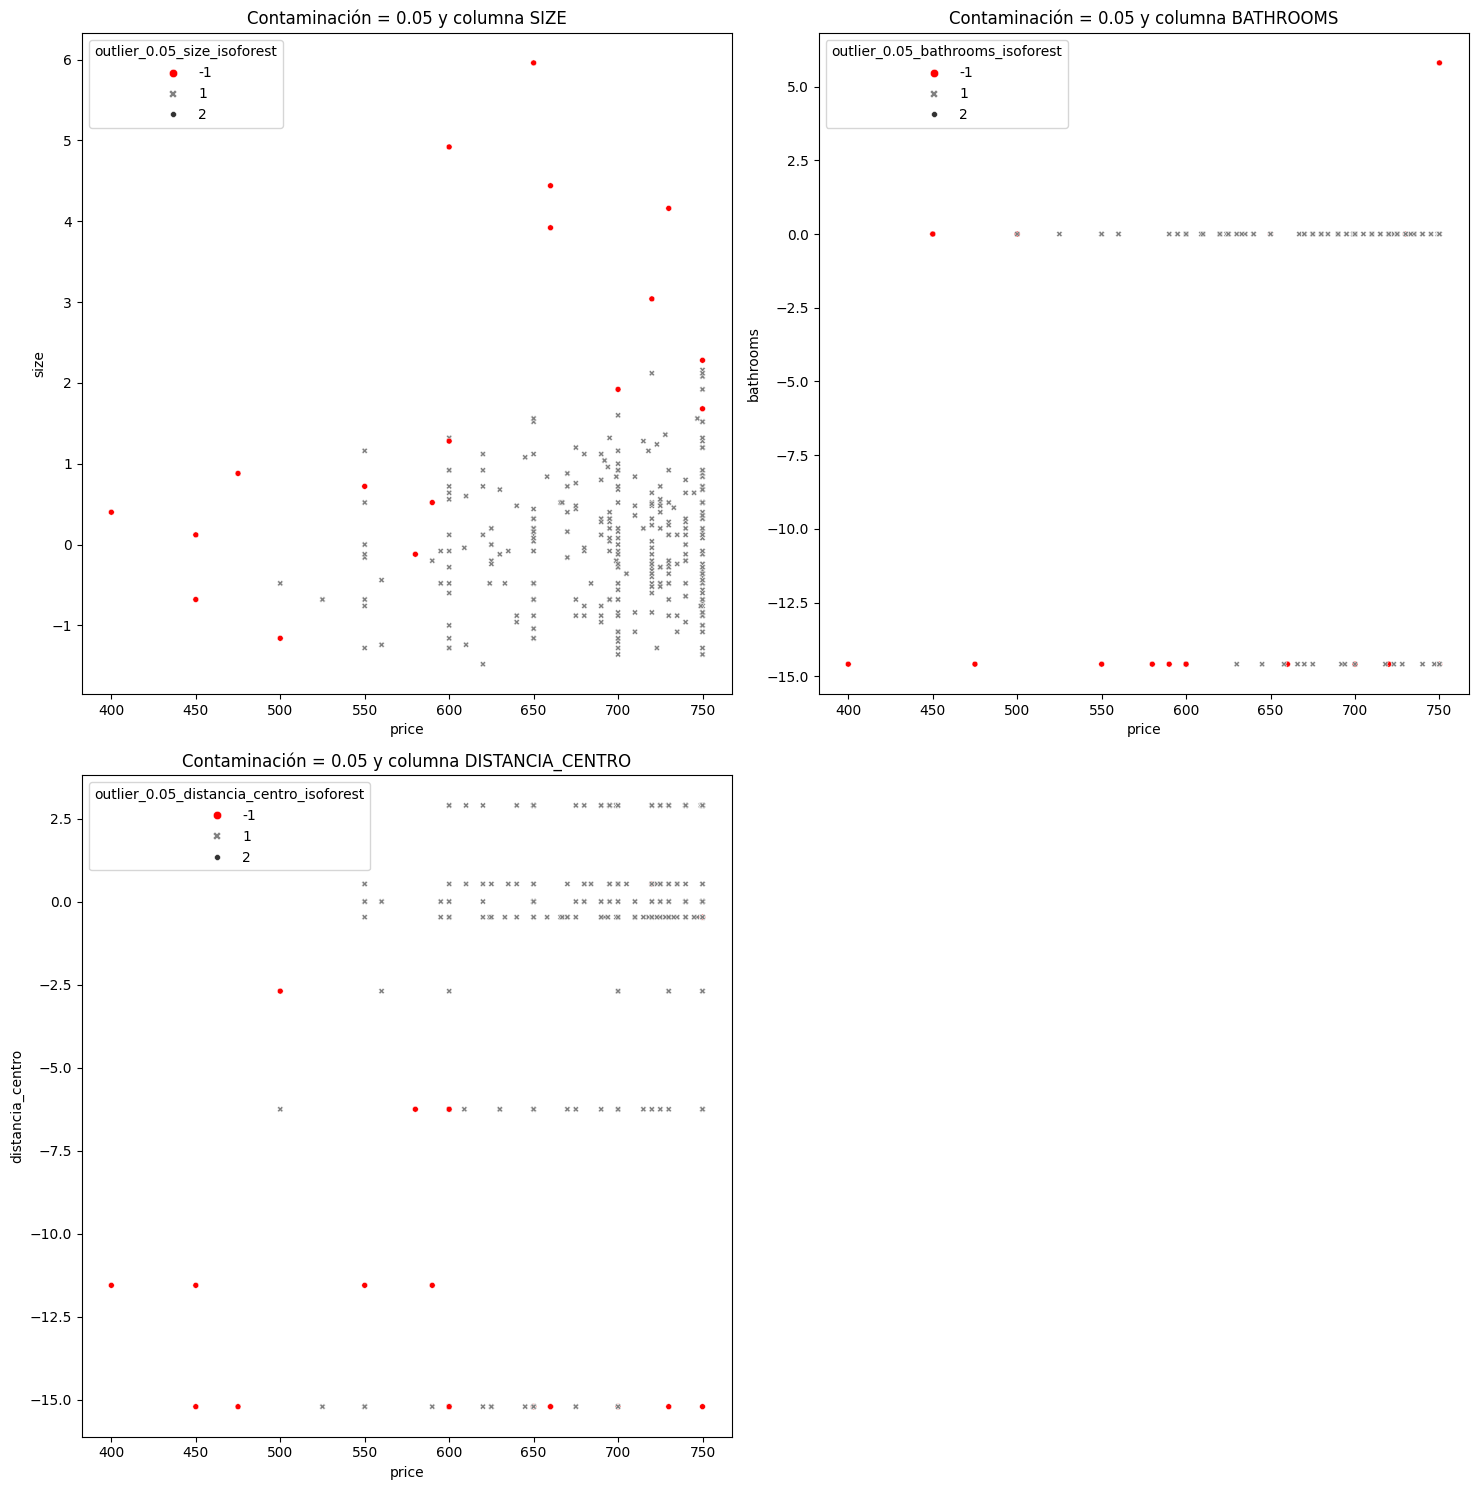

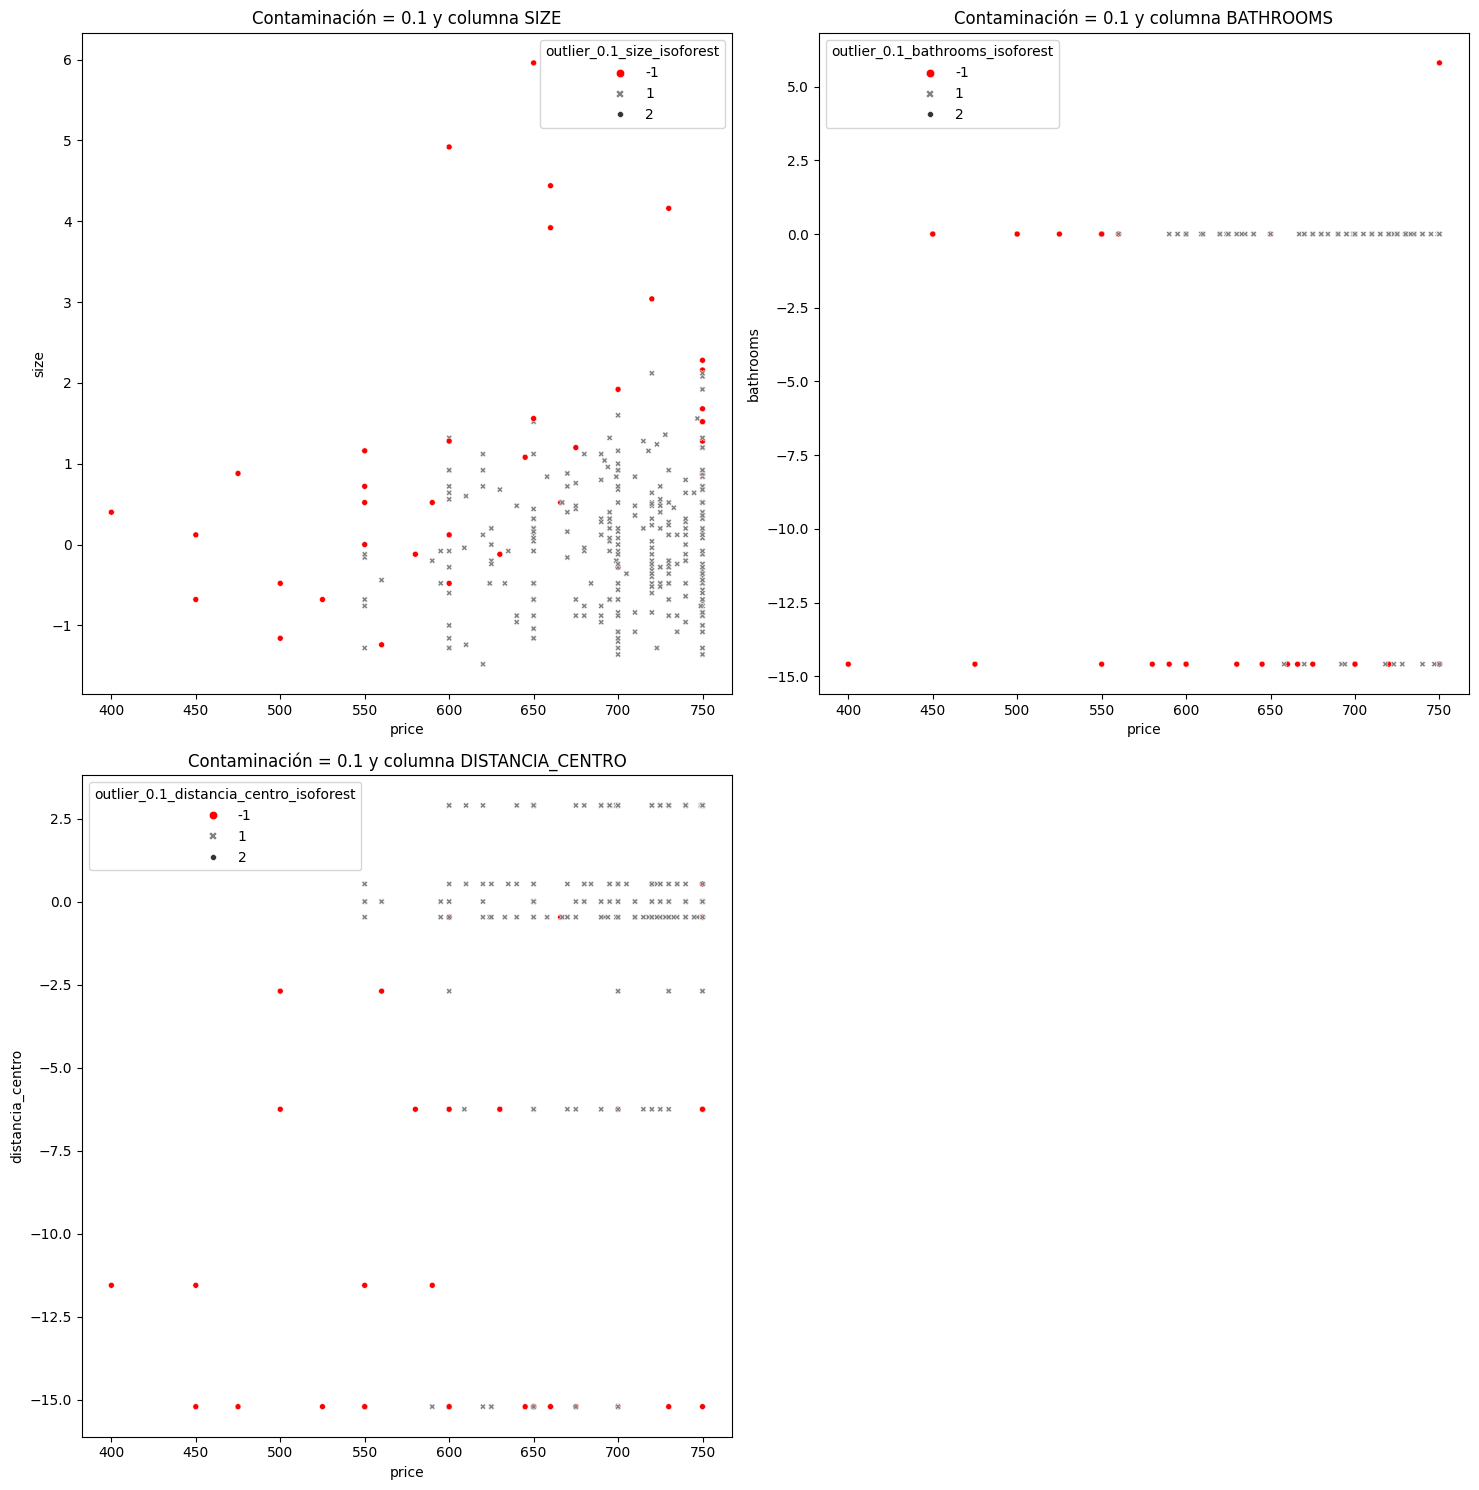

In [30]:
cols_analizar = ["size","bathrooms","municipality","distancia_centro","price"]
df_iso = explorar_outliers_if(df[cols_visualizar],df,"price",grafica_size=(15,15))

In [31]:
df_iso.sample()

,size,bathrooms,distancia_centro,price,propertyType_chalet,propertyType_countryHouse,propertyType_duplex,propertyType_flat,propertyType_penthouse,propertyType_studio,...,outlier_0.01_distancia_centro_isoforest,outlier_0.01_price_isoforest,outlier_0.05_size_isoforest,outlier_0.05_bathrooms_isoforest,outlier_0.05_distancia_centro_isoforest,outlier_0.05_price_isoforest,outlier_0.1_size_isoforest,outlier_0.1_bathrooms_isoforest,outlier_0.1_distancia_centro_isoforest,outlier_0.1_price_isoforest
293,-0.48,0.0,2.895607,750.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1,1,1,1,1,1,1,1,1,1


# Categorizamos los outliers de ambas pruebas
- Para comparar resultados
### Vamos a gestionar los outliers, los vamos a clasificar como
- "No es Outlier": Todas las columnas del LOF son 1
- "Improbable Outlier": El 60% de las columnas son 1
- "Es probable que sea Outlier": El 60% de las columnas son -1
- "Outlier Total": El 100% de las columnas son -1

### ¿Qué voy a hacer?
- Voy a contar cuantos 1 tengo en todas las columnas de outliers para poder categorizarla más adelante

#### Saber cuantas columnas de outlier tengo

In [32]:
len(df_lof.filter(like="outlier_").columns)

27

In [33]:
len(df_iso.filter(like="outlier_").columns)

12

- Tenemos 27 en df_lof
- Tenemos 12 en iso 

### LOF

In [34]:
# Generamos nueva columna
df_lof["tipo_outliers"] = 0

# Contamos cuantos -1 hay
for columna in df_lof.filter(like="outlier").columns:
    df_lof["tipo_outliers"] += (df_lof[columna] == -1).astype(int)

# Generamos el diccionario de condiciones y textos para reemplazar
condiciones = [
    df_lof["tipo_outliers"] == 0,
    df_lof["tipo_outliers"].between(1, 16,"both"),
    df_lof["tipo_outliers"].between(17, 26,"both"),
    df_lof["tipo_outliers"] == 27
]

textos = [
    "No es Outlier",
    "Improbable Outlier",
    "Probable Outlier",
    "Total Outlier"
]

# Reemplazamos la cuenta por el texto
df_lof["tipo_outliers"] = np.select(condiciones, textos, default="Unknown")

In [35]:
df_lof.sample()

,size,bathrooms,distancia_centro,price,propertyType_chalet,propertyType_countryHouse,propertyType_duplex,propertyType_flat,propertyType_penthouse,propertyType_studio,...,outlier_0.01_size_80vecinos_lof,outlier_0.01_bathrooms_80vecinos_lof,outlier_0.01_distancia_centro_80vecinos_lof,outlier_0.05_size_80vecinos_lof,outlier_0.05_bathrooms_80vecinos_lof,outlier_0.05_distancia_centro_80vecinos_lof,outlier_0.1_size_80vecinos_lof,outlier_0.1_bathrooms_80vecinos_lof,outlier_0.1_distancia_centro_80vecinos_lof,tipo_outliers
121,-0.12,-14.588688,-6.253815,630.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1,1,1,1,1,1,1,1,1,No es Outlier


### Isolation Forest

In [36]:
# Generamos nueva columna
df_iso["tipo_outliers"] = 0

# Contamos cuantos -1 hay
for columna in df_iso.filter(like="outlier").columns:
    df_iso["tipo_outliers"] += (df_iso[columna] == -1).astype(int)

# Generamos el diccionario de condiciones y textos para reemplazar
condiciones = [
    df_iso["tipo_outliers"] == 0,
    df_iso["tipo_outliers"].between(1, 7,"both"),
    df_iso["tipo_outliers"].between(8, 11,"both"),
    df_iso["tipo_outliers"] == 12
]

textos = [
    "No es Outlier",
    "Improbable Outlier",
    "Probable Outlier",
    "Total Outlier"
]

# Reemplazamos la cuenta por el texto
df_iso["tipo_outliers"] = np.select(condiciones, textos, default="Unknown")

In [37]:
df_iso.sample()

,size,bathrooms,distancia_centro,price,propertyType_chalet,propertyType_countryHouse,propertyType_duplex,propertyType_flat,propertyType_penthouse,propertyType_studio,...,outlier_0.01_price_isoforest,outlier_0.05_size_isoforest,outlier_0.05_bathrooms_isoforest,outlier_0.05_distancia_centro_isoforest,outlier_0.05_price_isoforest,outlier_0.1_size_isoforest,outlier_0.1_bathrooms_isoforest,outlier_0.1_distancia_centro_isoforest,outlier_0.1_price_isoforest,tipo_outliers
27,-1.28,0.0,-2.697308,750.0,0.0,0.0,0.0,0.0,0.0,1.0,...,1,1,1,1,1,1,1,1,1,No es Outlier


# Eliminar columnas que ya no necesitamos
- Nos quitamos las columnas de los outliers, ya las hemos categorizado

In [38]:
df_lof.drop(columns=df_lof.filter(like="outlier_").columns,inplace=True)
df_iso.drop(columns=df_iso.filter(like="outlier_").columns,inplace=True)

# Comparamos Métodos
- Veremos que detecciones han hecho cada uno

In [39]:
df_lof["tipo_outliers"].value_counts().reset_index()

,tipo_outliers,count
0,No es Outlier,268
1,Improbable Outlier,81
2,Probable Outlier,4


In [40]:
df_iso["tipo_outliers"].value_counts().reset_index()

,tipo_outliers,count
0,No es Outlier,317
1,Improbable Outlier,18
2,Probable Outlier,14
3,Total Outlier,4


# Utilizaremos el resultado de LOF
- Vamos a volver nulo el valor de todo lo que tenga como mínimo un resultado de que es un outlier

In [41]:
cols_nulificar = ["size","bathrooms","distancia_centro"]
for columna in cols_nulificar:
    df_lof.loc[df_lof["tipo_outliers"] == "Improbable Outlier", columna] = np.nan
    df_lof.loc[df_lof["tipo_outliers"] == "Probable Outlier", columna] = np.nan
    print(f"Se han vuelto nulos: {df_lof[columna].isnull().sum()} valores en {columna}")

Se han vuelto nulos: 85 valores en size
Se han vuelto nulos: 85 valores en bathrooms
Se han vuelto nulos: 85 valores en distancia_centro


# Rellenamos los nulos con Random Forest en Iterative

In [42]:
df = df_lof.copy()

In [43]:
df.isnull().sum()

size                         85
bathrooms                    85
distancia_centro             85
price                         0
propertyType_chalet           0
propertyType_countryHouse     0
propertyType_duplex           0
propertyType_flat             0
propertyType_penthouse        0
propertyType_studio           0
status_desconocido            0
status_good                   0
status_newdevelopment         0
status_renew                  0
rooms_1 habitacion            0
rooms_2 habitaciones          0
rooms_3 habitaciones          0
rooms_4 habitaciones          0
rooms_sin habitaciones        0
floor_bajo                    0
floor_cuarto                  0
floor_decimo cuarto           0
floor_desconocido             0
floor_entreplanta             0
floor_octavo                  0
floor_primero                 0
floor_quinto                  0
floor_segundo                 0
floor_septimo                 0
floor_sexto                   0
floor_sotano                  0
floor_te

In [45]:
cols_nulificar = ["size","bathrooms","distancia_centro"]
df_num = df[cols_nulificar]

# Random Forest
iterative_imputer = IterativeImputer(
    estimator=RandomForestRegressor(random_state=42),
    #max_iter=10,  # Número de iteraciones para ajustar los valores
    random_state=42
)

df_num_imputado = iterative_imputer.fit_transform(df_num)
df_num_sin_nulos = pd.DataFrame(df_num_imputado, columns=df_num.columns)
df_rf = df.copy()
df_rf[df_num.columns] = df_num_sin_nulos
df_rf[cols_nulificar].isnull().sum()


size                0
bathrooms           0
distancia_centro    0
dtype: int64

# Eliminamos "tipo_outliers"
- Ya la hemos utilizado como queríamos

In [46]:
df_rf.drop(columns=("tipo_outliers"),inplace=True)

# Guardamos 
- Nos vamos a intentar una regresión Lineal

In [47]:
df_rf.to_csv("../../datos/06_rent_outliers_gestionados.csv",index=False)